In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Imports
import warnings
warnings.filterwarnings('ignore')

import sys

if "google.colab" in sys.modules:
    !pip uninstall lightgbm -y
    !pip install lightgbm==3.3.1
    !pip install Levenshtein

import os
import gc
import time
import random
import pickle
import Levenshtein
import difflib
import multiprocessing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
from tqdm.auto import tqdm
from requests import get
from collections import Counter, defaultdict
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

Found existing installation: lightgbm 2.2.3
Uninstalling lightgbm-2.2.3:
  Successfully uninstalled lightgbm-2.2.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 4.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 258 kB 4.1 MB/s 
     |████████████████████████████████| 1.8 MB 61.1 MB/s 
     |████████████████████████████████| 103 kB 76.4 MB/s 


In [ ]:
def stratified_group_k_fold(X, y, groups, k, seed=None):
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

In [ ]:
def get_distribution(y_vals):
    y_distr = Counter(y_vals)
    y_vals_sum = sum(y_distr.values())
    return [f'{y_distr[i] / y_vals_sum:.2%}' for i in range(np.max(y_vals) + 1)]

In [ ]:
## Parameters
class CFG:
    AUTHOR = "kuruton"
    expID = ""
    if "google.colab" in sys.modules:
        expID = get("http://172.28.0.2:9000/api/sessions").json()[0]["name"].split(".")[0].split("-")[0]
    ROOT_DIR = '/content/drive/MyDrive/Kaggle/Foursquare'
    DATASET_DIR = os.path.join(ROOT_DIR, 'Dataset')
    INPUT_DIR = os.path.join(ROOT_DIR, 'Input')
    OUTPUT_DIR = os.path.join(ROOT_DIR, 'Output')
    is_debug = False
    SEED = 2022
    num_neighbors = 20
    num_split = 5
    feat_columns = ['name', 'address', 'city', 
                'state', 'zip', 'url', 
              'phone', 'categories', 'country']
    vec_columns = ['name', 'categories', 'address', 
                  'state', 'url', 'country']

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
seed_everything(CFG.SEED)

In [ ]:
if not os.path.exists(os.path.join(CFG.OUTPUT_DIR, CFG.expID)):
    os.makedirs(os.path.join(CFG.OUTPUT_DIR, CFG.expID))

In [ ]:
%load_ext Cython

In [ ]:
%%cython
def LCS(str S, str T):
    cdef int i, j
    cdef list dp = [[0] * (len(T) + 1) for _ in range(len(S) + 1)]
    for i in range(len(S)):
        for j in range(len(T)):
            dp[i + 1][j + 1] = max(dp[i][j] + (S[i] == T[j]), dp[i + 1][j], dp[i][j + 1], dp[i + 1][j + 1])
    return dp[len(S)][len(T)]

In [ ]:
def recall_knn(df, Neighbors = 10):
    print('Start knn grouped by country')
    train_df_country = []
    for country, country_df in tqdm(df.groupby('country')):
        country_df = country_df.reset_index(drop = True)

        neighbors = min(len(country_df), Neighbors)
        knn = KNeighborsRegressor(n_neighbors = neighbors,
                                    metric = 'haversine',
                                    n_jobs = -1)
        knn.fit(country_df[['latitude','longitude']], country_df.index)
        dists, nears = knn.kneighbors(country_df[['latitude', 'longitude']], 
                                        return_distance = True)

        for k in range(neighbors):            
            cur_df = country_df[['id', 'point_of_interest']]
            cur_df['match_id'] = country_df['id'].values[nears[:, k]]
            cur_df['kdist_country'] = dists[:, k]
            cur_df['kneighbors_country'] = k
            
            
            train_df_country.append(cur_df)
    train_df_country = pd.concat(train_df_country)
    
    print('Start knn')
    train_df = []
    knn = NearestNeighbors(n_neighbors = Neighbors)
    knn.fit(df[['latitude','longitude']], df.index)
    dists, nears = knn.kneighbors(df[['latitude','longitude']])
    
    for k in range(Neighbors):            
        cur_df = df[['id']]
        cur_df['match_id'] = df['id'].values[nears[:, k]]
        cur_df['kdist'] = dists[:, k]
        cur_df['kneighbors'] = k
        train_df.append(cur_df)
    
    train_df = pd.concat(train_df)
    train_df = train_df.merge(train_df_country,
                                 on = ['id', 'match_id'],
                                 how = 'outer')
    del train_df_country

    train_df['kdist_diff'] = (train_df['kdist'] - train_df['kdist_country']) /\
                    train_df['kdist_country']
    train_df['kneighbors_mean'] = train_df[['kneighbors', 'kneighbors_country']].mean(axis = 1)
    
    return train_df

In [ ]:
def add_features(df):    
    for col in tqdm(CFG.feat_columns):       
        if col in CFG.vec_columns:
            tv_fit = tfidf_d[col]
            indexs = [id2index_d[i] for i in df['id']]
            match_indexs = [id2index_d[i] for i in df['match_id']]                    
            df[f'{col}_sim'] = tv_fit[indexs].multiply(tv_fit[match_indexs]).sum(axis = 1).A.ravel()
        
        col_values = data.loc[df['id']][col].values.astype(str)
        matcol_values = data.loc[df['match_id']][col].values.astype(str)
        
        geshs = []
        levens = []
        jaros = []
        lcss = []
        for s, match_s in zip(col_values, matcol_values):
            if s != 'nan' and match_s != 'nan':                    
                geshs.append(difflib.SequenceMatcher(None, s, match_s).ratio())
                levens.append(Levenshtein.distance(s, match_s))
                jaros.append(Levenshtein.jaro_winkler(s, match_s))
                lcss.append(LCS(str(s), str(match_s)))
            else:
                geshs.append(np.nan)
                levens.append(np.nan)
                jaros.append(np.nan)
                lcss.append(np.nan)
        
        df[f'{col}_gesh'] = geshs
        df[f'{col}_leven'] = levens
        df[f'{col}_jaro'] = jaros
        df[f'{col}_lcs'] = lcss
        
        if col not in ['phone', 'zip']:
            df[f'{col}_len'] = list(map(len, col_values))
            df[f'match_{col}_len'] = list(map(len, matcol_values)) 
            df[f'{col}_len_diff'] = np.abs(df[f'{col}_len'] - df[f'match_{col}_len'])
            df[f'{col}_nleven'] = df[f'{col}_leven'] / \
                                    df[[f'{col}_len', f'match_{col}_len']].max(axis = 1)
            
            df[f'{col}_nlcsk'] = df[f'{col}_lcs'] / df[f'match_{col}_len']
            df[f'{col}_nlcs'] = df[f'{col}_lcs'] / df[f'{col}_len']
            
            df = df.drop(f'{col}_len', axis = 1)
            df = df.drop(f'match_{col}_len', axis = 1)
            gc.collect()
            
    return df

In [ ]:
def get_id2poi(input_df: pd.DataFrame) -> dict:
    return dict(zip(input_df['id'], input_df['point_of_interest']))

def get_poi2ids(input_df: pd.DataFrame) -> dict:
    return input_df.groupby('point_of_interest')['id'].apply(set).to_dict()

def get_score(input_df: pd.DataFrame):
    scores = []
    for id_str, matches in zip(input_df['id'].to_numpy(), input_df['matches'].to_numpy()):
        targets = poi2ids[id2poi[id_str]]
        preds = set(matches.split())
        score = len((targets & preds)) / len((targets | preds))
        scores.append(score)
    scores = np.array(scores)
    return scores.mean()

def analysis(df):
    print('Num of data: %s' % len(df))
    print('Num of unique id: %s' % df['id'].nunique())
    print('Num of unique poi: %s' % df['point_of_interest'].nunique())
    
    poi_grouped = df.groupby('point_of_interest')['id'].count().reset_index()
    print('Mean num of unique poi: %s' % poi_grouped['id'].mean())

In [ ]:
## Data load
if "google.colab" in sys.modules:
    data_root = CFG.INPUT_DIR
else:
    data_root = '../input/foursquare-location-matching'
data = pd.read_csv(os.path.join(data_root, 'train.csv'))

if CFG.is_debug:
    data = data.sample(n = 10000, random_state = CFG.SEED)
    data = data.reset_index(drop = True)

In [ ]:
data['POI_count'] = data['point_of_interest'].map(dict(data.groupby('point_of_interest')['id'].apply(len)))
data.loc[data['POI_count'] > 5, 'POI_count'] = 5
data['POI_count'] -= 1
data.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e,1
1,E_000002eae2a589,Carioca Manero,-22.907225,-43.178244,NaN,NaN,NaN,NaN,BR,NaN,NaN,Brazilian Restaurants,P_d82910d8382a83,1
2,E_000007f24ebc95,ร้านตัดผมการาเกด,13.780813,100.484900,NaN,NaN,NaN,NaN,TH,NaN,NaN,Salons / Barbershops,P_b1066599e78477,0
3,E_000008a8ba4f48,Turkcell,37.844510,27.844202,Adnan Menderes Bulvarı,NaN,NaN,NaN,TR,NaN,NaN,Mobile Phone Shops,P_b2ed86905a4cd3,0
4,E_00001d92066153,Restaurante Casa Cofiño,43.338196,-4.326821,NaN,Caviedes,Cantabria,NaN,ES,NaN,NaN,Spanish Restaurants,P_809a884d4407fb,1


In [ ]:
distrs = [get_distribution(data['POI_count'])]
index = ['training set']

for set_ind, (dev_ind, val_ind) in enumerate(stratified_group_k_fold(data, data['POI_count'], data["point_of_interest"], k=2, seed=CFG.SEED)):
    data.loc[val_ind, "set"] = set_ind

    dev_y, val_y = data.loc[dev_ind, 'POI_count'], data.loc[val_ind, 'POI_count']
    dev_groups, val_groups = data.loc[dev_ind, "point_of_interest"], data.loc[val_ind, "point_of_interest"]
    
    assert len(set(dev_groups) & set(val_groups)) == 0
    
    distrs.append(get_distribution(dev_y))
    index.append(f'development set - set {set_ind}')
    distrs.append(get_distribution(val_y))
    index.append(f'validation set - set {set_ind}')

display('Distribution per class:')
pd.DataFrame(distrs, index=index, columns=[f'Label {l}' for l in range(np.max(data['POI_count']) + 1)])

'Distribution per class:'

,Label 0,Label 1,Label 2,Label 3,Label 4
training set,37.32%,48.77%,6.38%,2.09%,5.44%
development set - set 0,37.32%,48.77%,6.38%,2.08%,5.44%
validation set - set 0,37.32%,48.77%,6.38%,2.09%,5.44%
development set - set 1,37.32%,48.77%,6.38%,2.09%,5.44%
validation set - set 1,37.32%,48.77%,6.38%,2.08%,5.44%


In [ ]:
# Data split
print('Num of train data: %s' % len(data))
print(data['set'].value_counts())

train_data = data.loc[data['set'] == 0]
test_data = data.loc[data['set'] == 1]

print('Train data: ')
analysis(train_data)
print('Test data: ')
analysis(test_data)

train_poi = train_data['point_of_interest'].unique().tolist()
test_poi = test_data['point_of_interest'].unique().tolist()

print(set(train_poi) & set(test_poi))

train_ids = train_data['id'].unique().tolist()
test_ids = test_data['id'].unique().tolist()
      
print(set(train_ids) & set(test_ids))
      
tv_ids_d = {}
tv_ids_d['train_ids'] = train_ids
tv_ids_d['test_ids'] = test_ids

np.save('tv_ids_d.npy', tv_ids_d)

del train_data, test_data
gc.collect()

data = data.set_index('id')
data = data.reset_index()

Num of train data: 1138812
0.0    569408
1.0    569404
Name: set, dtype: int64
Train data: 
Num of data: 569408
Num of unique id: 569408
Num of unique poi: 369986
Mean num of unique poi: 1.538998772926543
Test data: 
Num of data: 569404
Num of unique id: 569404
Num of unique poi: 369986
Mean num of unique poi: 1.538987961706659
set()
set()


In [ ]:
## Train data generated by knn
id2index_d = dict(zip(data['id'].values, data.index))

tfidf_d = {}
for col in CFG.vec_columns:
    tfidf = TfidfVectorizer()
    tfidf.fit(data.loc[data['set'] == 0, col].fillna('nan'))
    tv_fit = tfidf.transform(data[col].fillna('nan'))
    tfidf_d[col] = tv_fit

train_data = recall_knn(data.loc[data['set'] == 0], CFG.num_neighbors)
test_data = recall_knn(data.loc[data['set'] == 1], CFG.num_neighbors)

data = data.set_index('id')
ids = train_data['id'].tolist()
match_ids = train_data['match_id'].tolist()

poi = data.loc[ids]['point_of_interest'].values
match_poi = data.loc[match_ids]['point_of_interest'].values

train_data['label'] = np.array(poi == match_poi, dtype = np.int8)

test_ids = test_data['id'].tolist()
test_match_ids = test_data['match_id'].tolist()

test_poi = data.loc[test_ids]['point_of_interest'].values
test_match_poi = data.loc[test_match_ids]['point_of_interest'].values

test_data['label'] = np.array(test_poi == test_match_poi, dtype = np.int8)
del poi, match_poi, ids, match_ids, test_poi, test_match_poi, test_ids, test_match_ids
gc.collect()

print('Num of unique id: %s' % train_data['id'].nunique())
print('Num of train data: %s' % len(train_data))
print('Pos rate: %s' % train_data['label'].mean())
print(train_data.sample(5))

Start knn grouped by country


  0%|          | 0/206 [00:00<?, ?it/s]

Start knn
Start knn grouped by country


  0%|          | 0/209 [00:00<?, ?it/s]

Start knn
Num of unique id: 569408
Num of train data: 13916774
Pos rate: 0.07237136997410464
                       id          match_id     kdist  kneighbors  \
9669022  E_fb2423f3ecb535  E_ef0bc5de79e10b  0.002962        16.0   
4179479  E_5711e77f4f6716  E_88601b987e6f2c  0.013405         7.0   
2843346  E_fe5b07e0a8a9c5  E_0cffaaebc584d9  0.006918         4.0   
5672212  E_f624aa54796b00  E_b227f88db2fe18  0.003901         9.0   
1412325  E_7b07bee29838a7  E_8d81634e3378a0  0.001450         2.0   

        point_of_interest  kdist_country  kneighbors_country  kdist_diff  \
9669022  P_7aeff722d67fa9       0.001594                 8.0    0.858537   
4179479  P_728ab357db351e       0.013241                 7.0    0.012328   
2843346  P_5f256e9da11ffe       0.004618                 6.0    0.498116   
5672212  P_1ef23c0ca7dfdf       0.002758                 7.0    0.414395   
1412325  P_4507ac6a9d85a4       0.000710                 2.0    1.043830   

         kneighbors_mean  label  
9

In [ ]:
## Eval
data = data.reset_index()

id2poi = get_id2poi(data)
poi2ids = get_poi2ids(data)

eval_df = pd.DataFrame()
eval_df['id'] = data['id'].unique().tolist()
eval_df['match_id'] = eval_df['id']
print('Unique id: %s' % len(eval_df))

eval_df_ = train_data[train_data['label'] == 1][['id', 'match_id']]
eval_df = pd.concat([eval_df, eval_df_])

eval_df_ = test_data[test_data['label'] == 1][['id', 'match_id']]
eval_df = pd.concat([eval_df, eval_df_])

eval_df = eval_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
eval_df['matches'] = eval_df['match_id'].apply(lambda x: ' '.join(set(x)))
print('Unique id: %s' % len(eval_df))

iou_score = get_score(eval_df)
print('IoU score: %s' % iou_score)

Unique id: 1138812
Unique id: 1138812
IoU score: 0.9226548761979743


In [ ]:
distrs = [get_distribution(train_data["label"])]
index = ['training set']

for fold_ind, (dev_ind, val_ind) in enumerate(stratified_group_k_fold(train_data, train_data["label"], train_data["id"], k=CFG.num_split, seed=CFG.SEED)):
    train_data.loc[val_ind, "fold"] = fold_ind

    dev_y, val_y = train_data.loc[dev_ind, "label"], train_data.loc[val_ind, "label"]
    dev_groups, val_groups = train_data.loc[dev_ind, "id"], train_data.loc[val_ind, "id"]
    
    assert len(set(dev_groups) & set(val_groups)) == 0
    
    distrs.append(get_distribution(dev_y))
    index.append(f'development set - fold {fold_ind}')
    distrs.append(get_distribution(val_y))
    index.append(f'validation set - fold {fold_ind}')

display('Distribution per class:')
pd.DataFrame(distrs, index=index, columns=[f'Label {l}' for l in range(np.max(train_data["label"]) + 1)])

'Distribution per class:'

,Label 0,Label 1
training set,92.76%,7.24%
development set - fold 0,92.76%,7.24%
validation set - fold 0,92.76%,7.24%
development set - fold 1,92.76%,7.24%
validation set - fold 1,92.76%,7.24%
development set - fold 2,92.76%,7.24%
validation set - fold 2,92.76%,7.24%
development set - fold 3,92.76%,7.24%
validation set - fold 3,92.76%,7.24%
development set - fold 4,92.76%,7.24%


# model learning

In [ ]:
data = data.set_index('id')
train_data = add_features(train_data)

  0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
features = ['kdist','kneighbors','kdist_country','kneighbors_country', 'kdist_diff', 'kneighbors_mean']

columns = ['name', 'address', 'city', 'state',
       'zip', 'country', 'url', 'phone', 'categories']

for c in columns:
    if c == 'country':
        features += ['country_leven', 'country_sim', 'country_gesh', 'country_nleven']
        continue
    features += [f"{c}_gesh", f"{c}_jaro", f"{c}_lcs", f"{c}_leven"]
    if c == 'city':
        features += [f"{c}_len_diff", f"{c}_nleven", f"{c}_nlcsk", f"{c}_nlcs"]
    if c in ['address', 'categories', 'country', 'name', 'state', 'url']:
        features += [f"{c}_len_diff", f"{c}_nleven", f"{c}_nlcsk", f"{c}_nlcs", f"{c}_sim"]

print(len(features))
print(features)

71
['kdist', 'kneighbors', 'kdist_country', 'kneighbors_country', 'kdist_diff', 'kneighbors_mean', 'name_gesh', 'name_jaro', 'name_lcs', 'name_leven', 'name_len_diff', 'name_nleven', 'name_nlcsk', 'name_nlcs', 'name_sim', 'address_gesh', 'address_jaro', 'address_lcs', 'address_leven', 'address_len_diff', 'address_nleven', 'address_nlcsk', 'address_nlcs', 'address_sim', 'city_gesh', 'city_jaro', 'city_lcs', 'city_leven', 'city_len_diff', 'city_nleven', 'city_nlcsk', 'city_nlcs', 'state_gesh', 'state_jaro', 'state_lcs', 'state_leven', 'state_len_diff', 'state_nleven', 'state_nlcsk', 'state_nlcs', 'state_sim', 'zip_gesh', 'zip_jaro', 'zip_lcs', 'zip_leven', 'country_leven', 'country_sim', 'country_gesh', 'country_nleven', 'url_gesh', 'url_jaro', 'url_lcs', 'url_leven', 'url_len_diff', 'url_nleven', 'url_nlcsk', 'url_nlcs', 'url_sim', 'phone_gesh', 'phone_jaro', 'phone_lcs', 'phone_leven', 'categories_gesh', 'categories_jaro', 'categories_lcs', 'categories_leven', 'categories_len_diff', 'c

In [ ]:
def fit_lgb(X, y, params=None, es_rounds=20, seed=42,
             n_class=None, model_dir=None, folds=None):
    models = []

    trn_idx = folds!=0
    val_idx = folds==0
    X_train, y_train = X[trn_idx], y.iloc[trn_idx]
    X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]

    if model_dir is None:
        model = lgb.LGBMClassifier(**params)
        model.fit(
            X_train, y_train, 
            eval_set=[(X_valid, y_valid)],  
            early_stopping_rounds=es_rounds, 
            eval_metric='binary',  
#             verbose=-1)
            verbose=50)
    else:
        with open(f'{model_dir}/lgb_fold{i}.pkl', 'rb') as f:
            model = pickle.load(f)
        
    oof = model.predict_proba(X_valid)
    models.append(model)
    
    file = os.path.join(CFG.OUTPUT_DIR, os.path.join(CFG.expID, f'lgb.pkl'))
    pickle.dump(model, open(file, 'wb'))
    print()

    cv = (oof.argmax(axis=-1) == y_valid).mean()
    print(f"CV-accuracy: {cv}")

    return oof, models

def inference_lgb(models, feat_df):
    pred = np.array([model.predict_proba(feat_df) for model in models])
    pred = np.mean(pred, axis=0)
    return pred

In [ ]:
params = {
    'objective': "binary",
    'learning_rate': 0.2,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,

    'max_depth': 7,   
    'num_leaves': 35, 
    'n_estimators': 1000000, 
    "colsample_bytree": 0.9,
}


oof, models = fit_lgb(train_data[features], train_data["label"].astype(int), 
                      params=params, n_class=2, 
                      folds=train_data["fold"].values)

[50]	valid_0's binary_logloss: 0.0440086
[100]	valid_0's binary_logloss: 0.0422272
[150]	valid_0's binary_logloss: 0.0413376
[200]	valid_0's binary_logloss: 0.0407601
[250]	valid_0's binary_logloss: 0.0403253
[300]	valid_0's binary_logloss: 0.0399014
[350]	valid_0's binary_logloss: 0.0395466
[400]	valid_0's binary_logloss: 0.0392603
[450]	valid_0's binary_logloss: 0.0390068
[500]	valid_0's binary_logloss: 0.0387168
[550]	valid_0's binary_logloss: 0.038474
[600]	valid_0's binary_logloss: 0.0382808
[650]	valid_0's binary_logloss: 0.0380906
[700]	valid_0's binary_logloss: 0.0379252
[750]	valid_0's binary_logloss: 0.0377555
[800]	valid_0's binary_logloss: 0.0375693
[850]	valid_0's binary_logloss: 0.0373797
[900]	valid_0's binary_logloss: 0.0372128
[950]	valid_0's binary_logloss: 0.0370543
[1000]	valid_0's binary_logloss: 0.0369163
[1050]	valid_0's binary_logloss: 0.036763
[1100]	valid_0's binary_logloss: 0.0366316
[1150]	valid_0's binary_logloss: 0.0364797
[1200]	valid_0's binary_logloss: 

In [ ]:
del train_data
gc.collect()

89

#Check Feature Importances

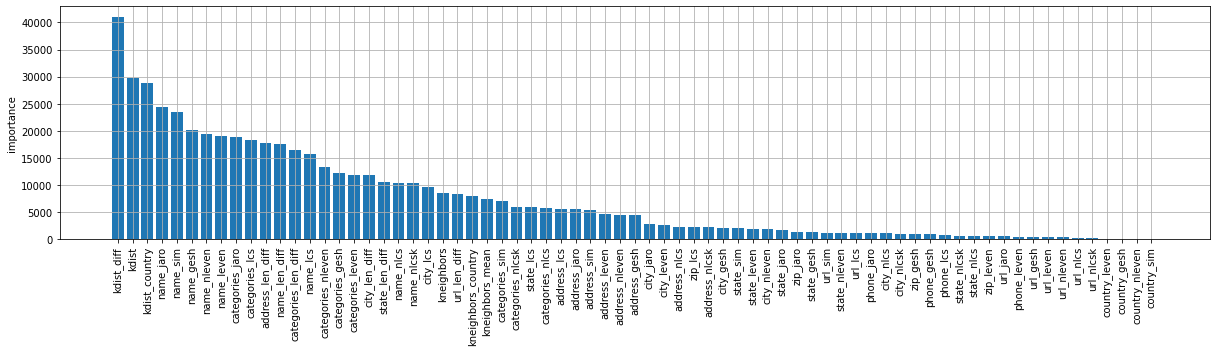

In [ ]:
def plot_importances(models):
    importance_df = pd.DataFrame(models[0].feature_importances_, 
                                 index=features, 
                                 columns=['importance'])\
                        .sort_values("importance", ascending=False)

    plt.subplots(figsize=(len(features) // 4, 5))
    plt.bar(importance_df.index, importance_df.importance)
    plt.grid()
    plt.xticks(rotation=90)
    plt.ylabel("importance")
    plt.tight_layout()
    plt.show()

plot_importances(models)

#Check CV

In [ ]:
test_data = add_features(test_data)
pred = inference_lgb(models, test_data[features])
test_data['pred'] = pred[:, 1]

  0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
def post_process(df):
    id2match = dict(zip(df['id'].values, df['matches'].str.split()))

    for base, match in df[['id', 'matches']].values:
        match = match.split()
        if len(match) == 1:        
            continue

        for m in match:
            if base not in id2match[m]:
                id2match[m].append(base)
    df['matches'] = df['id'].map(id2match).map(' '.join)
    return df 

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 4.3 MB/s 
     |████████████████████████████████| 81 kB 9.1 MB/s 
     |████████████████████████████████| 210 kB 67.9 MB/s 
     |████████████████████████████████| 78 kB 6.2 MB/s 
     |████████████████████████████████| 49 kB 3.5 MB/s 
     |████████████████████████████████| 112 kB 72.2 MB/s 
     |████████████████████████████████| 146 kB 59.2 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=c64a1c538558cb25ecde99727b3ceca4e0e47cfcf2d452b05811b413f7917582
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
import optuna

def objective(trial):
    x = trial.suggest_uniform('threshold', 0, 1)
    test_pred_df = test_data[test_data['pred'] > x][['id', 'match_id']]
    out_df = pd.DataFrame()
    out_df['id'] = test_data['id'].unique().tolist()
    out_df['match_id'] = out_df['id']
    out_df = pd.concat([out_df, test_pred_df])
    out_df = out_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
    out_df['matches'] = out_df['match_id'].apply(lambda x: ' '.join(set(x)))
    out_df = post_process(out_df)

    score = get_score(out_df)
    print(f"CV: {score:.6f}")
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-05-25 18:29:11,897] A new study created in memory with name: no-name-2a7d882c-1191-4c26-9069-fe8f804a67e8
[I 2022-05-25 18:29:50,664] Trial 0 finished with value: 0.7933941245840028 and parameters: {'threshold': 0.12095785906651346}. Best is trial 0 with value: 0.7933941245840028.


CV: 0.793394


[I 2022-05-25 18:30:09,065] Trial 1 finished with value: 0.7990781158058118 and parameters: {'threshold': 0.9605602853721862}. Best is trial 1 with value: 0.7990781158058118.


CV: 0.799078


[I 2022-05-25 18:30:30,108] Trial 2 finished with value: 0.7985407396737286 and parameters: {'threshold': 0.1413679918761741}. Best is trial 1 with value: 0.7990781158058118.


CV: 0.798541


[I 2022-05-25 18:30:49,226] Trial 3 finished with value: 0.8269585310231744 and parameters: {'threshold': 0.6815678964308044}. Best is trial 3 with value: 0.8269585310231744.


CV: 0.826959


[I 2022-05-25 18:31:10,058] Trial 4 finished with value: 0.8113280862102227 and parameters: {'threshold': 0.22032720171418263}. Best is trial 3 with value: 0.8269585310231744.


CV: 0.811328


[I 2022-05-25 18:31:30,604] Trial 5 finished with value: 0.7770583042980291 and parameters: {'threshold': 0.07705267013247641}. Best is trial 3 with value: 0.8269585310231744.


CV: 0.777058


[I 2022-05-25 18:31:50,293] Trial 6 finished with value: 0.8241688544317691 and parameters: {'threshold': 0.7892374817339257}. Best is trial 3 with value: 0.8269585310231744.


CV: 0.824169


[I 2022-05-25 18:32:10,257] Trial 7 finished with value: 0.8273095809096808 and parameters: {'threshold': 0.6385766201184362}. Best is trial 7 with value: 0.8273095809096808.


CV: 0.827310


[I 2022-05-25 18:32:31,139] Trial 8 finished with value: 0.8033023168583494 and parameters: {'threshold': 0.16454692716431008}. Best is trial 7 with value: 0.8273095809096808.


CV: 0.803302


[I 2022-05-25 18:32:51,497] Trial 9 finished with value: 0.8250056672122271 and parameters: {'threshold': 0.43707122858657155}. Best is trial 7 with value: 0.8273095809096808.


CV: 0.825006


[I 2022-05-25 18:33:10,895] Trial 10 finished with value: 0.826329605815168 and parameters: {'threshold': 0.49253151202633655}. Best is trial 7 with value: 0.8273095809096808.


CV: 0.826330


[I 2022-05-25 18:33:30,898] Trial 11 finished with value: 0.8268266912889382 and parameters: {'threshold': 0.6947062861302404}. Best is trial 7 with value: 0.8273095809096808.


CV: 0.826827


[I 2022-05-25 18:33:49,928] Trial 12 finished with value: 0.8272256312154725 and parameters: {'threshold': 0.6501154046882518}. Best is trial 7 with value: 0.8273095809096808.


CV: 0.827226


[I 2022-05-25 18:34:10,255] Trial 13 finished with value: 0.8224780451285252 and parameters: {'threshold': 0.3710714502399035}. Best is trial 7 with value: 0.8273095809096808.


CV: 0.822478


[I 2022-05-25 18:34:30,418] Trial 14 finished with value: 0.8274453353356281 and parameters: {'threshold': 0.6124699683935508}. Best is trial 14 with value: 0.8274453353356281.


CV: 0.827445


[I 2022-05-25 18:34:49,071] Trial 15 finished with value: 0.8175944848187643 and parameters: {'threshold': 0.8782037817449327}. Best is trial 14 with value: 0.8274453353356281.


CV: 0.817594


[I 2022-05-25 18:35:09,061] Trial 16 finished with value: 0.827359434065429 and parameters: {'threshold': 0.5714313131047435}. Best is trial 14 with value: 0.8274453353356281.


CV: 0.827359


[I 2022-05-25 18:35:29,718] Trial 17 finished with value: 0.8199584191074286 and parameters: {'threshold': 0.3228245696723231}. Best is trial 14 with value: 0.8274453353356281.


CV: 0.819958


[I 2022-05-25 18:35:48,978] Trial 18 finished with value: 0.8272049991824778 and parameters: {'threshold': 0.5513839311971698}. Best is trial 14 with value: 0.8274453353356281.


CV: 0.827205


[I 2022-05-25 18:36:09,138] Trial 19 finished with value: 0.827377961259109 and parameters: {'threshold': 0.5686229695648521}. Best is trial 14 with value: 0.8274453353356281.


CV: 0.827378


[I 2022-05-25 18:36:28,027] Trial 20 finished with value: 0.8252879953190757 and parameters: {'threshold': 0.7631586647415884}. Best is trial 14 with value: 0.8274453353356281.


CV: 0.825288


[I 2022-05-25 18:36:48,095] Trial 21 finished with value: 0.8272229840372904 and parameters: {'threshold': 0.5526613229730002}. Best is trial 14 with value: 0.8274453353356281.


CV: 0.827223


[I 2022-05-25 18:37:08,849] Trial 22 finished with value: 0.8273691026391068 and parameters: {'threshold': 0.567915585374337}. Best is trial 14 with value: 0.8274453353356281.


CV: 0.827369


[I 2022-05-25 18:37:28,220] Trial 23 finished with value: 0.8247606797960803 and parameters: {'threshold': 0.4296246843877565}. Best is trial 14 with value: 0.8274453353356281.


CV: 0.824761


[I 2022-05-25 18:37:48,835] Trial 24 finished with value: 0.8177792297183396 and parameters: {'threshold': 0.2910356609679722}. Best is trial 14 with value: 0.8274453353356281.


CV: 0.817779


[I 2022-05-25 18:38:08,728] Trial 25 finished with value: 0.8260102355132147 and parameters: {'threshold': 0.7408334990000353}. Best is trial 14 with value: 0.8274453353356281.


CV: 0.826010


[I 2022-05-25 18:38:28,062] Trial 26 finished with value: 0.8261810551563689 and parameters: {'threshold': 0.48550405249071954}. Best is trial 14 with value: 0.8274453353356281.


CV: 0.826181


[I 2022-05-25 18:38:47,726] Trial 27 finished with value: 0.8221913393638947 and parameters: {'threshold': 0.8238683592322242}. Best is trial 14 with value: 0.8274453353356281.


CV: 0.822191


[I 2022-05-25 18:39:08,595] Trial 28 finished with value: 0.8273703105976388 and parameters: {'threshold': 0.6265649586421851}. Best is trial 14 with value: 0.8274453353356281.


CV: 0.827370


[I 2022-05-25 18:39:32,848] Trial 29 finished with value: 0.8274506500082699 and parameters: {'threshold': 0.6156427299823263}. Best is trial 29 with value: 0.8274506500082699.


CV: 0.827451


[I 2022-05-25 18:39:53,248] Trial 30 finished with value: 0.8158956272792831 and parameters: {'threshold': 0.8909220134223546}. Best is trial 29 with value: 0.8274506500082699.


CV: 0.815896


[I 2022-05-25 18:40:13,298] Trial 31 finished with value: 0.8273918620276709 and parameters: {'threshold': 0.621363365755577}. Best is trial 29 with value: 0.8274506500082699.


CV: 0.827392


[I 2022-05-25 18:40:40,151] Trial 32 finished with value: 0.5278886104739707 and parameters: {'threshold': 0.0018345272295566262}. Best is trial 29 with value: 0.8274506500082699.


CV: 0.527889


[I 2022-05-25 18:41:00,129] Trial 33 finished with value: 0.8274949784021387 and parameters: {'threshold': 0.592744640466258}. Best is trial 33 with value: 0.8274949784021387.


CV: 0.827495


[I 2022-05-25 18:41:21,529] Trial 34 finished with value: 0.8273923458399646 and parameters: {'threshold': 0.6225674139116084}. Best is trial 33 with value: 0.8274949784021387.


CV: 0.827392


[I 2022-05-25 18:41:41,624] Trial 35 finished with value: 0.8263972724077502 and parameters: {'threshold': 0.7202892208790576}. Best is trial 33 with value: 0.8274949784021387.


CV: 0.826397


[I 2022-05-25 18:42:00,927] Trial 36 finished with value: 0.824691130932507 and parameters: {'threshold': 0.4273438657939549}. Best is trial 33 with value: 0.8274949784021387.


CV: 0.824691


[I 2022-05-25 18:42:20,679] Trial 37 finished with value: 0.7942453678382523 and parameters: {'threshold': 0.9691518737446849}. Best is trial 33 with value: 0.8274949784021387.


CV: 0.794245


[I 2022-05-25 18:42:40,620] Trial 38 finished with value: 0.8269900534968349 and parameters: {'threshold': 0.6784362904419232}. Best is trial 33 with value: 0.8274949784021387.


CV: 0.826990


[I 2022-05-25 18:43:00,356] Trial 39 finished with value: 0.8236360680183618 and parameters: {'threshold': 0.8009864945194345}. Best is trial 33 with value: 0.8274949784021387.


CV: 0.823636


[I 2022-05-25 18:43:19,701] Trial 40 finished with value: 0.8259380845122088 and parameters: {'threshold': 0.4735599322480743}. Best is trial 33 with value: 0.8274949784021387.


CV: 0.825938


[I 2022-05-25 18:43:39,723] Trial 41 finished with value: 0.827449984143918 and parameters: {'threshold': 0.6135323132259228}. Best is trial 33 with value: 0.8274949784021387.


CV: 0.827450


[I 2022-05-25 18:43:59,707] Trial 42 finished with value: 0.8274534570250653 and parameters: {'threshold': 0.603293319639536}. Best is trial 33 with value: 0.8274949784021387.


CV: 0.827453


[I 2022-05-25 18:44:20,019] Trial 43 finished with value: 0.8266449148001692 and parameters: {'threshold': 0.5148261052679187}. Best is trial 33 with value: 0.8274949784021387.


CV: 0.826645


[I 2022-05-25 18:44:40,051] Trial 44 finished with value: 0.826764368443984 and parameters: {'threshold': 0.7003251572613334}. Best is trial 33 with value: 0.8274949784021387.


CV: 0.826764


[I 2022-05-25 18:44:59,215] Trial 45 finished with value: 0.8274593851369552 and parameters: {'threshold': 0.6094416347173075}. Best is trial 33 with value: 0.8274949784021387.


CV: 0.827459


[I 2022-05-25 18:45:23,171] Trial 46 finished with value: 0.8266995921817317 and parameters: {'threshold': 0.5182050255262739}. Best is trial 33 with value: 0.8274949784021387.


CV: 0.826700


[I 2022-05-25 18:45:42,494] Trial 47 finished with value: 0.8272352966821802 and parameters: {'threshold': 0.65364231987909}. Best is trial 33 with value: 0.8274949784021387.


CV: 0.827235


[I 2022-05-25 18:46:02,743] Trial 48 finished with value: 0.8226447378174607 and parameters: {'threshold': 0.3749239317182481}. Best is trial 33 with value: 0.8274949784021387.


CV: 0.822645


[I 2022-05-25 18:46:22,378] Trial 49 finished with value: 0.8209990810085982 and parameters: {'threshold': 0.8409055245507194}. Best is trial 33 with value: 0.8274949784021387.


CV: 0.820999


[I 2022-05-25 18:46:42,437] Trial 50 finished with value: 0.8275151147910951 and parameters: {'threshold': 0.5948318838890894}. Best is trial 50 with value: 0.8275151147910951.


CV: 0.827515


[I 2022-05-25 18:47:01,688] Trial 51 finished with value: 0.8275137946075679 and parameters: {'threshold': 0.5947124971099654}. Best is trial 50 with value: 0.8275151147910951.


CV: 0.827514


[I 2022-05-25 18:47:21,634] Trial 52 finished with value: 0.8270649015930628 and parameters: {'threshold': 0.6753156241066123}. Best is trial 50 with value: 0.8275151147910951.


CV: 0.827065


[I 2022-05-25 18:47:41,609] Trial 53 finished with value: 0.8274286305606228 and parameters: {'threshold': 0.5995789066462343}. Best is trial 50 with value: 0.8275151147910951.


CV: 0.827429


[I 2022-05-25 18:48:01,802] Trial 54 finished with value: 0.8268543791995925 and parameters: {'threshold': 0.5252919133858365}. Best is trial 50 with value: 0.8275151147910951.


CV: 0.826854


[I 2022-05-25 18:48:21,173] Trial 55 finished with value: 0.8255365880298395 and parameters: {'threshold': 0.45406940323436684}. Best is trial 50 with value: 0.8275151147910951.


CV: 0.825537


[I 2022-05-25 18:48:41,050] Trial 56 finished with value: 0.8273356715883707 and parameters: {'threshold': 0.5801162819223559}. Best is trial 50 with value: 0.8275151147910951.


CV: 0.827336


[I 2022-05-25 18:49:00,785] Trial 57 finished with value: 0.8254897365732119 and parameters: {'threshold': 0.7567406861978385}. Best is trial 50 with value: 0.8275151147910951.


CV: 0.825490


[I 2022-05-25 18:49:21,794] Trial 58 finished with value: 0.8269431343683508 and parameters: {'threshold': 0.5320389970192887}. Best is trial 50 with value: 0.8275151147910951.


CV: 0.826943


[I 2022-05-25 18:49:46,978] Trial 59 finished with value: 0.8271326733068683 and parameters: {'threshold': 0.6674882112393293}. Best is trial 50 with value: 0.8275151147910951.


CV: 0.827133


[I 2022-05-25 18:50:08,346] Trial 60 finished with value: 0.8236774949715605 and parameters: {'threshold': 0.396400595518495}. Best is trial 50 with value: 0.8275151147910951.


CV: 0.823677


[I 2022-05-25 18:50:28,437] Trial 61 finished with value: 0.8274780581253466 and parameters: {'threshold': 0.5913800181532117}. Best is trial 50 with value: 0.8275151147910951.


CV: 0.827478


[I 2022-05-25 18:50:47,625] Trial 62 finished with value: 0.8274094986748604 and parameters: {'threshold': 0.584166215360456}. Best is trial 50 with value: 0.8275151147910951.


CV: 0.827409


[I 2022-05-25 18:51:07,484] Trial 63 finished with value: 0.8264431300663008 and parameters: {'threshold': 0.7181753301289291}. Best is trial 50 with value: 0.8275151147910951.


CV: 0.826443


[I 2022-05-25 18:51:27,598] Trial 64 finished with value: 0.8271901265388046 and parameters: {'threshold': 0.5482189688099235}. Best is trial 50 with value: 0.8275151147910951.


CV: 0.827190


[I 2022-05-25 18:51:47,788] Trial 65 finished with value: 0.8272198196084685 and parameters: {'threshold': 0.6520608099965016}. Best is trial 50 with value: 0.8275151147910951.


CV: 0.827220


[I 2022-05-25 18:52:08,014] Trial 66 finished with value: 0.8274902064182016 and parameters: {'threshold': 0.5918803155615462}. Best is trial 50 with value: 0.8275151147910951.


CV: 0.827490


[I 2022-05-25 18:52:27,447] Trial 67 finished with value: 0.8263581279112535 and parameters: {'threshold': 0.49411615937373254}. Best is trial 50 with value: 0.8275151147910951.


CV: 0.826358


[I 2022-05-25 18:52:47,571] Trial 68 finished with value: 0.8273494900026864 and parameters: {'threshold': 0.575068193932985}. Best is trial 50 with value: 0.8275151147910951.


CV: 0.827349


[I 2022-05-25 18:53:06,679] Trial 69 finished with value: 0.8272746838825539 and parameters: {'threshold': 0.6413594109333853}. Best is trial 50 with value: 0.8275151147910951.


CV: 0.827275


[I 2022-05-25 18:53:26,923] Trial 70 finished with value: 0.8258007271355647 and parameters: {'threshold': 0.46648897527163236}. Best is trial 50 with value: 0.8275151147910951.


CV: 0.825801


[I 2022-05-25 18:53:47,049] Trial 71 finished with value: 0.8274377575922444 and parameters: {'threshold': 0.6115491998650352}. Best is trial 50 with value: 0.8275151147910951.


CV: 0.827438


[I 2022-05-25 18:54:06,380] Trial 72 finished with value: 0.8272330926472989 and parameters: {'threshold': 0.5556889104079978}. Best is trial 50 with value: 0.8275151147910951.


CV: 0.827233


[I 2022-05-25 18:54:26,430] Trial 73 finished with value: 0.8274657537675946 and parameters: {'threshold': 0.590206392081956}. Best is trial 50 with value: 0.8275151147910951.


CV: 0.827466


[I 2022-05-25 18:54:46,499] Trial 74 finished with value: 0.8274626423176773 and parameters: {'threshold': 0.5979229331736279}. Best is trial 50 with value: 0.8275151147910951.


CV: 0.827463


[I 2022-05-25 18:55:06,573] Trial 75 finished with value: 0.8268527096603041 and parameters: {'threshold': 0.6938789296052621}. Best is trial 50 with value: 0.8275151147910951.


CV: 0.826853


[I 2022-05-25 18:55:26,988] Trial 76 finished with value: 0.8270785868878009 and parameters: {'threshold': 0.5403597434107387}. Best is trial 50 with value: 0.8275151147910951.


CV: 0.827079


[I 2022-05-25 18:55:46,481] Trial 77 finished with value: 0.8263586380820342 and parameters: {'threshold': 0.49439134951687574}. Best is trial 50 with value: 0.8275151147910951.


CV: 0.826359


[I 2022-05-25 18:56:06,504] Trial 78 finished with value: 0.8262536226060972 and parameters: {'threshold': 0.7278262650076603}. Best is trial 50 with value: 0.8275151147910951.


CV: 0.826254


[I 2022-05-25 18:56:25,767] Trial 79 finished with value: 0.8272650720925211 and parameters: {'threshold': 0.6467753163175364}. Best is trial 50 with value: 0.8275151147910951.


CV: 0.827265


[I 2022-05-25 18:56:45,946] Trial 80 finished with value: 0.8274841854986558 and parameters: {'threshold': 0.5915571150181277}. Best is trial 50 with value: 0.8275151147910951.


CV: 0.827484


[I 2022-05-25 18:57:06,304] Trial 81 finished with value: 0.8273959536568022 and parameters: {'threshold': 0.5830935842690611}. Best is trial 50 with value: 0.8275151147910951.


CV: 0.827396


[I 2022-05-25 18:57:25,772] Trial 82 finished with value: 0.8274864730427541 and parameters: {'threshold': 0.5967577271898495}. Best is trial 50 with value: 0.8275151147910951.


CV: 0.827486


[I 2022-05-25 18:57:46,166] Trial 83 finished with value: 0.8273224773288019 and parameters: {'threshold': 0.5616440802354362}. Best is trial 50 with value: 0.8275151147910951.


CV: 0.827322


[I 2022-05-25 18:58:05,561] Trial 84 finished with value: 0.8265558101468421 and parameters: {'threshold': 0.5063434429715294}. Best is trial 50 with value: 0.8275151147910951.


CV: 0.826556


[I 2022-05-25 18:58:25,481] Trial 85 finished with value: 0.827284396121811 and parameters: {'threshold': 0.6397090396931814}. Best is trial 50 with value: 0.8275151147910951.


CV: 0.827284


[I 2022-05-25 18:58:45,589] Trial 86 finished with value: 0.8274142729964894 and parameters: {'threshold': 0.5843424830269373}. Best is trial 50 with value: 0.8275151147910951.


CV: 0.827414


[I 2022-05-25 18:59:05,695] Trial 87 finished with value: 0.8108270251972982 and parameters: {'threshold': 0.2162800318481337}. Best is trial 50 with value: 0.8275151147910951.


CV: 0.810827


[I 2022-05-25 18:59:25,716] Trial 88 finished with value: 0.8267876526339031 and parameters: {'threshold': 0.697944092798957}. Best is trial 50 with value: 0.8275151147910951.


CV: 0.826788


[I 2022-05-25 18:59:44,944] Trial 89 finished with value: 0.8271250793221618 and parameters: {'threshold': 0.6668680596907547}. Best is trial 50 with value: 0.8275151147910951.


CV: 0.827125


[I 2022-05-25 19:00:05,264] Trial 90 finished with value: 0.8269885968817864 and parameters: {'threshold': 0.5348577066630954}. Best is trial 50 with value: 0.8275151147910951.


CV: 0.826989


[I 2022-05-25 19:00:25,521] Trial 91 finished with value: 0.8274386119303855 and parameters: {'threshold': 0.5989833562195332}. Best is trial 50 with value: 0.8275151147910951.


CV: 0.827439


[I 2022-05-25 19:00:45,605] Trial 92 finished with value: 0.8273691630224883 and parameters: {'threshold': 0.6269696005921519}. Best is trial 50 with value: 0.8275151147910951.


CV: 0.827369


[I 2022-05-25 19:01:05,814] Trial 93 finished with value: 0.8274540223662153 and parameters: {'threshold': 0.6022071524768464}. Best is trial 50 with value: 0.8275151147910951.


CV: 0.827454


[I 2022-05-25 19:01:25,168] Trial 94 finished with value: 0.8272780823854045 and parameters: {'threshold': 0.5594613802486518}. Best is trial 50 with value: 0.8275151147910951.


CV: 0.827278


[I 2022-05-25 19:01:45,359] Trial 95 finished with value: 0.8273693447367825 and parameters: {'threshold': 0.6270978781313229}. Best is trial 50 with value: 0.8275151147910951.


CV: 0.827369


[I 2022-05-25 19:02:04,709] Trial 96 finished with value: 0.8266354283913564 and parameters: {'threshold': 0.5145181004258963}. Best is trial 50 with value: 0.8275151147910951.


CV: 0.826635


[I 2022-05-25 19:02:25,048] Trial 97 finished with value: 0.8254239809606493 and parameters: {'threshold': 0.4492003887460859}. Best is trial 50 with value: 0.8275151147910951.


CV: 0.825424


[I 2022-05-25 19:02:45,223] Trial 98 finished with value: 0.8275075587493583 and parameters: {'threshold': 0.5945393190887944}. Best is trial 50 with value: 0.8275151147910951.


CV: 0.827508


[I 2022-05-25 19:03:04,475] Trial 99 finished with value: 0.8274886729052551 and parameters: {'threshold': 0.5918051454402925}. Best is trial 50 with value: 0.8275151147910951.


CV: 0.827489


In [ ]:
threshold = study.best_params['threshold']
threshold

0.5948318838890894

In [ ]:
study.best_value

0.8275151147910951

In [ ]:
test_pred_df = test_data[test_data['pred'] > threshold][['id', 'match_id']]
out_df = pd.DataFrame()
out_df['id'] = test_data['id'].unique().tolist()
out_df['match_id'] = out_df['id']
out_df = pd.concat([out_df, test_pred_df])
out_df = out_df.groupby('id')['match_id'].\
                    apply(list).reset_index()
out_df['matches'] = out_df['match_id'].apply(lambda x: ' '.join(set(x)))
out_df = post_process(out_df)

score = get_score(out_df)
print(f"CV: {score:.6f}")

CV: 0.827515


# 間違っているものの中身を見る

In [ ]:
data = data.reset_index()

labelが1なのに0と予測しているもの

In [ ]:
false_negative = test_data.loc[(test_data["label"] == 1) & (test_data["pred"] <= threshold), :]
false_negative.describe()

,kdist,kneighbors,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,name_sim,name_gesh,name_leven,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
count,139923.000000,139923.000000,135620.000000,135620.000000,130565.000000,143882.000000,143882.0,143882.000000,143882.000000,143882.000000,...,143882.000000,143878.000000,143878.000000,143878.000000,143878.000000,143882.000000,143878.000000,143878.000000,143878.000000,1.438820e+05
mean,0.006324,6.190305,0.003457,6.213044,0.422840,6.482048,1.0,0.262967,0.410838,16.523596,...,0.998923,0.999027,0.001988,0.999020,1.998054,0.000028,0.000994,0.999027,0.999027,1.710959e-01
std,0.048347,5.243556,0.023046,5.251401,2.396975,5.308975,0.0,0.310336,0.250085,9.481942,...,0.032804,0.030673,0.062356,0.030992,0.061346,0.005273,0.031178,0.030673,0.030673,1.830769e-01
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.943029e-13
25%,0.000440,2.000000,0.000331,2.000000,0.005877,2.000000,1.0,0.000000,0.208955,10.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,1.000000,1.000000,1.203814e-02
50%,0.001103,4.000000,0.000850,4.000000,0.056450,5.000000,1.0,0.000000,0.392157,15.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,1.000000,1.000000,9.282617e-02
75%,0.003020,10.000000,0.002332,10.000000,0.319477,10.000000,1.0,0.512094,0.590909,22.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,1.000000,1.000000,3.053005e-01
max,4.310371,19.000000,2.388985,19.000000,214.206825,19.000000,1.0,1.000000,1.000000,59.000000,...,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,5.948298e-01


In [ ]:
false_negative.sample(min(false_negative.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
5249742,E_381762cb9968eb,E_210e2ca7826468,0.000000,9.0,NaN,NaN,NaN,NaN,9.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.007448
4518320,E_ef4787aba84fd1,E_a191685d79bc4b,0.000306,7.0,P_6068a0ec346b8c,0.000305,7.0,0.001997,7.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.000004
786569,E_6194641239d922,E_94220057f33ecd,0.000048,1.0,P_ba3096e9ff9398,0.000014,1.0,2.351780,1.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.242070
1810388,E_2dc7f7993ad76e,E_2afacb08fefb44,0.000277,3.0,P_e10d9a91f00eac,0.000260,5.0,0.062388,4.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.008947
1046631,E_d65ca1a435bc0b,E_9f3ae4aba520ad,0.000229,1.0,P_5aab0e28f538fd,0.000172,1.0,0.332987,1.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.253239
968408,E_b3199975e732ac,E_8637632b335a77,0.000313,1.0,P_385d04fb09b16f,0.000244,1.0,0.282070,1.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.224539
3515288,E_2c4800a6a08931,E_78d0ca62526dd8,0.000043,6.0,P_eaf6d99ea4a4a1,0.000043,11.0,0.000162,8.5,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.001362
2401626,E_3794bca080319c,E_976217c47b407b,0.002230,4.0,P_866bdf11821c70,0.002073,4.0,0.075995,4.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.001351
797798,E_6680c127583d5c,E_7287d2af312d9b,0.002437,1.0,P_fecc86b67b653a,0.001884,1.0,0.293262,1.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.413054
11207429,E_ae85207f55e63b,E_50461acae5fc59,0.001491,19.0,P_dc3926ef24d60e,0.000767,12.0,0.943438,15.5,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.080047


In [ ]:
for id, match_id in false_negative.sample(min(false_negative.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
321178,E_48358e4ecec73f,O'Key,60.055645,30.314344,NaN,NaN,NaN,NaN,RU,NaN,NaN,Supermarkets,P_0de08c018f4b71,4,1.0
1060108,E_ee3d167faff459,Новый Окей🍕,60.056787,30.309295,NaN,NaN,NaN,NaN,RU,NaN,NaN,Miscellaneous Shops,P_0de08c018f4b71,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
264803,E_3b76cc374aa8bb,SDÜ Doğu Yerleşkesi,37.828049,30.530401,NaN,NaN,NaN,NaN,TR,NaN,NaN,Bus Stops,P_218c3d6f92c0c9,4,1.0
749167,E_a84e34b5fee9bf,19 Mayıs Amfisi,37.829370,30.526281,NaN,NaN,Isparta,NaN,TR,NaN,NaN,Festivals,P_218c3d6f92c0c9,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
251046,E_385f0ba0b8a572,内視鏡室,35.703384,139.74228,津久戸町5-1,新宿区,東京都,162-0821,JP,NaN,NaN,Medical Labs,P_b3dd5e61dce84b,4,1.0
938050,E_d2b43a43c75af9,JCHO東京新宿メディカルセンター 駐輪場,35.703777,139.74206,津久戸町5-1,新宿区,東京都,162-8543,JP,NaN,NaN,Parking,P_b3dd5e61dce84b,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
673628,E_97521554a70d3a,Valset Apart Hotel 11 корпус,43.672389,40.294512,NaN,NaN,NaN,NaN,RU,NaN,NaN,Bed & Breakfasts,P_4fe86a3edba5f1,1,1.0
1126652,E_fd420d90ec9ab0,Valset Apartments,43.672791,40.294912,"ул. Каменка, 2",Estosadok,Krasnodarskiy Kray,NaN,RU,NaN,NaN,Vacation Rentals,P_4fe86a3edba5f1,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
589667,E_84895fa2dc3da4,Роддом👶👶,59.448468,32.023694,NaN,NaN,NaN,NaN,RU,NaN,NaN,Maternity Clinics,P_a345bb12d7b162,1,1.0
766282,E_ac1df0db92332d,родильное отделение,59.447931,32.024206,NaN,NaN,NaN,NaN,RU,NaN,NaN,Maternity Clinics,P_a345bb12d7b162,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
861672,E_c18a83db1fab19,成田空港第2駐車場 (P2),35.773316,140.386599,古込1-1,成田市,千葉県,282-0004,JP,http://www.narita-airport.jp,476345350,Parking,P_1af0aad7d5c50a,1,1.0
1023875,E_e60d8e636b71c1,成田空港 第2 38番,35.773977,140.386306,古込1-1,成田市,千葉県,282-0004,JP,NaN,NaN,Parking,P_1af0aad7d5c50a,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
486740,E_6d64398ce940df,The Emirates Lounge,35.774121,140.388099,古込1,成田市,千葉県,286-0104,JP,NaN,NaN,Airport Lounges,P_6f01f6c4ff1250,1,1.0
1023237,E_e5eb3a3c9c8522,エミレーツラウンジ,35.773474,140.388809,NaN,成田市,千葉県,286-0104,JP,NaN,NaN,Airport Lounges,P_6f01f6c4ff1250,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
351154,E_4ee8df6956f4cd,RM Pondok Angkasa Ciganea,-6.157815,106.852876,Jl angkasa raya 32 blok A 13,Kemayoran Jakarta,NaN,NaN,ID,NaN,NaN,Indonesian Restaurants,P_617d38685531bb,4,1.0
422201,E_5eda0abe3e4936,Rumah makan Ibu Haji Ciganea,-6.157595,106.853151,Jl Angkasa Pura,Jakarta Pusat,NaN,NaN,ID,NaN,NaN,Sundanese Restaurants,P_617d38685531bb,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
66402,E_0edffba8f85c40,Pink Sisters,14.126502,120.962359,NaN,NaN,NaN,NaN,PH,NaN,NaN,Churches,P_7c20426744f584,2,1.0
742435,E_a6cc07b6498e38,Adoration Convent of Divine Mercy,14.126307,120.962251,Arnoldus Rd.,Tagaytay City,Cavite,NaN,PH,NaN,NaN,"Churches, Spiritual Centers",P_7c20426744f584,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
398989,E_59a660adb95a1c,Snoring!!.,1.344341,103.693955,Blk 843 Jurong West Street 81,NaN,NaN,NaN,SG,NaN,NaN,Housing Developments,P_05167815f10de1,4,1.0
939896,E_d31c9c89006b7c,Snores!!.,1.344100,103.694127,Blk 843 Jurong West Street 81,NaN,NaN,NaN,SG,NaN,NaN,Housing Developments,P_05167815f10de1,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
365843,E_5233268fdd6861,Coinstar,41.0267,-73.6311,160 W Putnam Ave,Greenwich,CT,06830,US,http://www.coinstar.com,8009282274,Banks,P_8ace07d10e0492,1,1.0
741130,E_a680cda8e516fa,Coinstar,41.0270,-73.6313,161 W Putnam Ave,Greenwich,CT,06830,US,http://www.coinstar.com,8009282274,Banks,P_8ace07d10e0492,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
285017,E_3ffc4786088b18,Горбушкин Двор,55.741520,37.504670,NaN,NaN,NaN,NaN,RU,NaN,NaN,Miscellaneous Shops,P_53c7884e9564af,4,1.0
303263,E_44192bc3cede47,Gorba,55.742128,37.504753,NaN,NaN,NaN,NaN,RU,NaN,NaN,Flea Markets,P_53c7884e9564af,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
684179,E_99aeee5c5b3aa9,Banco Nacional de Fomento,-27.332735,-55.867324,14 de Mayo,Encarnación,Paraguay,NaN,PY,NaN,NaN,Banks,P_d75e4103326c56,1,1.0
936673,E_d267ce0792d23d,Banco Nacional de Fomento - Suc. Encarnación,-27.333500,-55.866251,14 De Mayo,Encarnacion,NaN,NaN,PY,NaN,+59571202242,Buildings,P_d75e4103326c56,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
554732,E_7cad1d4c4963ff,Epil Deluxe,55.75266,37.585403,"Новинский Бульвар, 10/12",NaN,NaN,NaN,RU,NaN,NaN,Salons / Barbershops,P_178e6036e4c113,1,1.0
573348,E_80df9aa8fe0e48,Академия Красоты,55.75304,37.585032,"Новинский бул., 10/12",Москва,Москва,NaN,RU,http://acadepil.ru,+74957710039,Salons / Barbershops,P_178e6036e4c113,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
573307,E_80dc748acdec42,"PT. Bank Panin, Tbk.",-6.228431,106.799998,NaN,Jakarta Pusat,DKI Jakarta,10270,ID,NaN,NaN,Offices,P_0423eb97e20fe3,4,1.0
807489,E_b554e12a2b2e7f,Panin Kantor Pusat,-6.228652,106.799400,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_0423eb97e20fe3,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
188515,E_2a4b0b5f2b1446,Walmart Supercenter,29.443389,-98.642149,8923 W Military Dr,San Antonio,TX,78245,US,https://www.walmart.com/store/2239/san-antonio...,2106755092,"Big Box Stores, Supermarkets, Grocery Stores",P_6ef49450e2d3ce,1,1.0
521207,E_752397c59a0697,Wal Mart Auto Center,29.443218,-98.642242,Military Drive,San Antonio,TX,78251,US,NaN,NaN,Automotive Shops,P_6ef49450e2d3ce,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
363536,E_51afbede996b8d,Ondokuz Mayıs Üniversitesi,41.373461,36.213657,Samsun,Samsun,NaN,NaN,TR,NaN,NaN,Universities,P_a283644b3fd6e8,4,1.0
522014,E_755325b5e9798b,19 Mayıs Üniversitesi Kampüs İçi,41.372065,36.209707,"Kurupelit Kampüsü, Atakum",NaN,NaN,NaN,TR,NaN,NaN,Parks,P_a283644b3fd6e8,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
443893,E_63c3934daa006c,Sauna De Waterhoeve,50.965030,3.983748,"Serskampstraat 32, 9230 Wetteren",Wetteren,Vlaams Gewest,9230,BE,NaN,NaN,Saunas / Steam Rooms,P_bd9728089ffc6d,1,1.0
1012685,E_e381a36d26f129,De Waterhoeve,50.969377,3.937495,Serskampstraat 32,Smetlede,Oost-Vlaanderen,9340,BE,http://www.sauna-dewaterhoeve.be,478335155,"Spas, Saunas / Steam Rooms",P_bd9728089ffc6d,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
420744,E_5e86bf7789b5b9,Павильон А20,55.796107,37.592303,NaN,NaN,NaN,NaN,RU,NaN,NaN,Electronics Stores,P_d5eaa3e226fe86,4,1.0
525568,E_761807deb87a05,Савок,55.793779,37.591352,NaN,NaN,NaN,NaN,RU,NaN,NaN,Electronics Stores,P_d5eaa3e226fe86,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
234242,E_3492da2e5ec80a,"3/F Parking Level, The Globe Tower",14.554742,121.051368,"32nd Street, Bonifacio Global City",Taguig City,NaN,NaN,PH,NaN,NaN,Parking,P_6ffcd0d7911f38,4,1.0
1128957,E_fdc39b38e15fd0,18/F The Globe Tower,14.553881,121.049600,32nd Avenue corner 7th Avenue,Taguig City,NaN,1634,PH,NaN,NaN,Coworking Spaces,P_6ffcd0d7911f38,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
255387,E_395bc9051eee1c,morning bakery,1.124154,104.043025,Ruko Green Land,Batam,Kepulauan Riau,NaN,ID,NaN,NaN,"Coffee Shops, Cafés",P_68529bac16a489,1,1.0
276854,E_3e24e11f4b4551,Morning Coffe Shop,1.129430,104.037804,Komp. Ruko Citra Indah,Batam Centre,NaN,NaN,ID,NaN,NaN,Cafés,P_68529bac16a489,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
469274,E_6975e1df7ad821,Komplek Ujungberung Indah Blok 19,-6.911026,107.698212,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_235ecc4e492f97,4,1.0
593593,E_8568e9959a3eea,komplek ujung berung indah,-6.909727,107.701387,My Office.. (∩_∩),Bandung,NaN,NaN,ID,NaN,NaN,NaN,P_235ecc4e492f97,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
110706,E_18cd927fd47078,kmp rajarakata,-5.869545,105.753410,NaN,NaN,NaN,NaN,ID,NaN,NaN,Boats or Ferries,P_2769dafac3aa32,4,1.0
924497,E_cfab6871c6e5f8,Pelabuhan Penyeberangan Bakauheni,-5.867305,105.754565,Jalan Pelabuhan Bakauheni,Bandar Lampung,Lampung,NaN,ID,NaN,NaN,Boats or Ferries,P_2769dafac3aa32,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
196821,E_2c27fd2563c905,Camp Dearborn Cabin H 21,42.585602,-83.636612,General Motors Road,Milford,MI,48380,US,NaN,NaN,Campgrounds,P_292005d7d137e1,4,1.0
935338,E_d21afcf98993f9,C3 Bunk,42.581830,-83.634163,NaN,Milford,MI,48380,US,NaN,NaN,Campgrounds,P_292005d7d137e1,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
79938,E_11df4c891619c9,Hasgülpark Tatil Sitesi,36.572299,35.396799,Karataş,NaN,NaN,NaN,TR,NaN,NaN,Residential Buildings (Apartments / Condos),P_27b75dfd69d3ea,1,1.0
755354,E_a9ae500150846b,hasgülpark sitesi,36.571924,35.396992,NaN,NaN,NaN,NaN,TR,NaN,NaN,Residential Buildings (Apartments / Condos),P_27b75dfd69d3ea,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
324903,E_490d4b81a18d90,Dtac Center,15.694858,100.121784,V-Square Plaza,Nakhon Sawan,Changwat Nakhon Sawan,60000,TH,NaN,NaN,"IT Services, Mobile Phone Shops",P_57d83fe0a5dd20,1,1.0
724175,E_a2a9b47c165c07,DTAC SHOP บิ๋กซี,15.694236,100.121927,V-Square,Pak Nam Pho,Nakhon Sawan,NaN,TH,NaN,NaN,NaN,P_57d83fe0a5dd20,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
488145,E_6db939459b2ea9,glass room,46.074634,18.242034,NaN,NaN,NaN,NaN,HU,NaN,NaN,Libraries,P_87f275f986cab4,2,1.0
671811,E_96e8dca2483c4b,City Library,46.074604,18.242336,Hungary,Pecs,NaN,NaN,HU,NaN,NaN,Libraries,P_87f275f986cab4,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
234724,E_34ae8db4c651e8,仔记大炒,3.133334,101.712131,16-44 Jalan San Peng 55200,Kuala Lumpur,WP Kuala Lumpur,NaN,MY,NaN,NaN,Chinese Restaurants,P_04b538bb67eaf0,1,1.0
772163,E_ad6c75d0744b39,Restoran Zai Kee,3.133842,101.712248,"28, Jalan San Peng, Pudu",Kuala Lumpur,Kuala Lumpur,55200,MY,NaN,+60102764738,Cantonese Restaurants,P_04b538bb67eaf0,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
659551,E_9432865c1c8923,Istanbul Ataturk Olimpiyat Stadyumu,41.061030,28.766233,NaN,NaN,NaN,NaN,TR,NaN,NaN,Stadiums,P_5fa3bc7ab81895,4,1.0
1037336,E_e90ee06a8784eb,Olympiastadion,41.074415,28.766084,NaN,NaN,NaN,NaN,TR,NaN,NaN,NaN,P_5fa3bc7ab81895,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
559796,E_7dd1282619b666,Unisuper,-29.927995,-51.161212,Monte Castelo,Canoas,RS,92025-370,BR,NaN,NaN,"Markets, Storage Facilities",P_ac0175f1665af2,1,1.0
872507,E_c3fb5540796fbd,Supermercado Viezzer,-29.927991,-51.163398,"R. Monte Castelo, 1149",Canoas,RS,92025-370,BR,http://www.unisuper.com.br,5134765451,Supermarkets,P_ac0175f1665af2,1,1.0


labelが0なのに1と予測しているもの

In [ ]:
false_positive = test_data.loc[(test_data["label"] == 0) & (test_data["pred"] > threshold), :]
false_positive.describe()

,kdist,kneighbors,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,name_sim,name_gesh,name_leven,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
count,59005.000000,59005.000000,57170.000000,57170.000000,55486.000000,60202.000000,60202.0,60202.000000,60192.000000,60192.000000,...,60202.000000,60199.000000,60199.000000,60199.000000,60199.000000,60202.0,60199.000000,60199.000000,60199.000000,60202.000000
mean,0.009010,4.813677,0.003597,4.805492,0.409668,5.072340,0.0,0.573947,0.595445,12.411566,...,0.997874,0.998015,0.004153,0.997929,1.996030,0.0,0.002076,0.998015,0.998015,0.833717
std,0.207197,4.915439,0.015523,4.905771,1.666829,5.035246,0.0,0.350790,0.249673,9.345368,...,0.046062,0.043900,0.090860,0.045379,0.087799,0.0,0.045430,0.043900,0.043900,0.127430
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.594832
25%,0.000309,1.000000,0.000236,1.000000,0.007397,1.000000,0.0,0.324175,0.428571,5.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.0,0.000000,1.000000,1.000000,0.720362
50%,0.000904,3.000000,0.000680,3.000000,0.065831,3.000000,0.0,0.639631,0.608696,11.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.0,0.000000,1.000000,1.000000,0.851094
75%,0.003111,7.000000,0.002302,7.000000,0.314606,8.000000,0.0,0.867027,0.784438,17.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.0,0.000000,1.000000,1.000000,0.955091
max,31.458202,19.000000,0.960753,19.000000,103.877569,19.000000,0.0,1.000000,1.000000,57.000000,...,1.000000,1.000000,2.000000,1.000000,2.000000,0.0,1.000000,1.000000,1.000000,1.000000


In [ ]:
false_positive.sample(min(false_positive.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
1301631,E_492027d731ddd2,E_af6dc6d78389c9,0.026012,2.0,P_34cce58ff90b51,0.021810,2.0,0.192664,2.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.946019
1063407,E_ddeff073f11c0a,E_6b9274755035da,0.000024,1.0,P_fd49217f6933fe,0.000012,1.0,1.061956,1.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.765432
1470790,E_9502eb8ebfb146,E_1dd3da701e6eb5,0.002155,2.0,P_3099acbe6c5825,0.002154,13.0,0.000423,7.5,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.652532
694977,E_384ce338f13de1,E_131b19db20dc24,0.012872,1.0,P_1c7d11377f524d,0.012617,1.0,0.020245,1.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.807766
1098723,E_edd2299d2e850d,E_883777708f71da,0.004073,1.0,NaN,NaN,NaN,NaN,1.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.632351
8640307,E_2c7523b26a7a3d,E_5a3598fe2e1cee,0.003821,15.0,P_d949fb867fe0ec,0.003821,15.0,0.000084,15.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.988425
2322253,E_14082d6d187e1c,E_4cbc2b8c80e056,0.011138,4.0,P_f236d927241fd3,0.010735,7.0,0.037491,5.5,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.793584
3146764,E_86894f56041590,E_10cec0596ad556,0.002154,5.0,P_bab7dad6dbe315,0.001672,8.0,0.288159,6.5,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.836242
1131715,E_fcc94580747074,E_0d697afb70b65b,0.002299,1.0,P_1cb7c2bc28fa3d,0.001937,1.0,0.186621,1.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.742728
11049837,E_67b2a87d2cc6f7,E_f61b91fba63475,0.001921,19.0,NaN,NaN,NaN,NaN,19.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.954032


In [ ]:
for id, match_id in false_positive.sample(min(false_positive.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
11363,E_02964cfa576d93,Ауд.3055,55.671169,37.488897,NaN,NaN,NaN,NaN,RU,NaN,NaN,College Auditoriums,P_4775b8a45155cb,0,1.0
240080,E_35e2f435dccb6c,Лекция МЭО,55.671220,37.488619,NaN,NaN,NaN,NaN,RU,NaN,NaN,College Auditoriums,P_38d362a234e00d,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
222623,E_31ff181d8891c6,TrueCoffee (ทรูคอฟฟี่),13.758331,100.564932,IT Mall Fortune Town,Din Daeng,Bangkok,10400,TH,http://www.truecoffee.com,NaN,Coffee Shops,P_69ec0d0f4afe31,1,1.0
609905,E_891bd3c8bacceb,TrueCoffee (ทรูคอฟฟี่),13.758383,100.564980,Fortune Town,Din Daeng,Bangkok,10400,TH,NaN,NaN,Coffee Shops,P_f52f78eab2d05c,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
145677,E_20a60893765062,Clothes PSC17,35.272267,-80.669344,NaN,Charlotte,NC,NaN,US,NaN,NaN,Clothing Stores,P_4c5da033c20162,4,1.0
482219,E_6c61ae41a11689,Clothes 46,35.271984,-80.669351,NaN,Charlotte,NC,NaN,US,NaN,NaN,Clothing Stores,P_ddfad104812aa6,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
932096,E_d16065c62e7fd6,Bursa 2.Sulh Hukuk Mahkemesi,40.193171,29.070104,NaN,NaN,NaN,NaN,TR,NaN,NaN,Courthouses,P_1fbbb6b67f3d7d,1,1.0
1065714,E_ef827fc4b36cd4,Bursa 9. Ağır Ceza Mahkemesi,40.193146,29.070206,NaN,NaN,NaN,NaN,TR,NaN,NaN,Courthouses,P_c604c556246c58,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
209660,E_2f0f4c781e2909,X-8 SMAN 17 Bandung,-6.941717,107.574945,Jln. Tujuhbelas,Bandung,NaN,NaN,ID,NaN,NaN,College Classrooms,P_a21e8467b91106,4,1.0
469562,E_69880cce40b040,XI IPS 3 SMAN 17 Bandung,-6.942161,107.574914,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_f6b86faaff5a6f,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1004824,E_e1b7e4a8bdbfc7,Väsby-Grillen,59.517796,17.915195,NaN,Upplands Väsby Municipality,NaN,194 34,SE,NaN,NaN,"Burger Joints, BBQ Joints",P_e1f12c2899900f,1,1.0
1117522,E_fb3adc292b8ab1,Väsby Centrum,59.518592,17.911904,Dragonvägen 86,Upplands Väsby,NaN,194 33,SE,http://www.vasbycentrum.se/,84535045,Shopping Malls,P_81a82deb75ab00,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
231458,E_33f4928b28d198,pizza17,36.346128,-119.320069,NaN,Visalia,CA,93291,US,NaN,NaN,Pizza Places,P_8ca54406128e02,0,1.0
1046991,E_eb42c8fc729390,pizza1,36.346086,-119.319876,NaN,Visalia,CA,93291,US,NaN,NaN,Pizza Places,P_bfa7e6d0413df5,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
2480,E_00955ec9056412,estadio olimpico mangueirao - torcida do paysandu,-1.381173,-48.443935,NaN,NaN,NaN,NaN,BR,NaN,NaN,Soccer Stadiums,P_7049505299954e,0,1.0
301162,E_439ebea723156d,"Estadio Olimpico do Pará, Mangueirão",-1.381225,-48.443871,NaN,NaN,NaN,NaN,BR,NaN,NaN,Stadiums,P_d6e0346be78bd1,3,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
543038,E_7a07e5138afb15,Miànbão Diàn 02,-19.562913,-42.637196,NaN,NaN,NaN,NaN,BR,NaN,NaN,"College Libraries, Bakeries, Brazilian Restaur...",P_f69b58b249a9ad,1,1.0
833037,E_bb128953e1e8d1,CFEM 02,-19.562459,-42.634946,NaN,NaN,NaN,NaN,BR,NaN,NaN,Breakfast Spots,P_0a1311ea371bd7,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
428932,E_606413f392ff92,Frontbar De Geverfde Vogel,50.82522,3.265394,NaN,NaN,NaN,NaN,BE,NaN,NaN,Bars,P_07ae9a7555af00,2,1.0
469534,E_6985a8970fdba3,Café 56,50.82533,3.265324,Burgemeester August Reynaertstraat 13,Kortrijk,West-Vlaanderen,8500,BE,NaN,+32496390335,Bars,P_2ef957dbdf3bce,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
536708,E_789c27c788e001,Академика Анохина 6 корп. 3,55.668473,37.469237,"ул. Академика Анохина, 6, корп. 3",Москва,NaN,119602,RU,NaN,NaN,Residential Buildings (Apartments / Condos),P_ed253ba60397fa,0,1.0
808334,E_b58723a7c44d6e,"ул. Академика Анохина, 6, корп. 4",55.669116,37.471132,"ул. Академика Анохина, 6, корп. 4",Москва,NaN,NaN,RU,NaN,NaN,Residential Buildings (Apartments / Condos),P_2e2a52dbdc0a63,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
12946,E_02ef3a238ce128,서울시립대 종합강의동,37.584906,127.056870,NaN,Seoul,NaN,NaN,KR,NaN,NaN,College Academic Buildings,P_7e1610171235cb,0,1.0
195157,E_2bc896b86536a5,서울시립대 학생회관 여학생휴게실,37.583694,127.060075,NaN,NaN,NaN,NaN,KR,NaN,NaN,Buildings,P_d076484bd4f81f,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
674525,E_9786cda7299542,Sportpaleis,51.040118,3.724333,NaN,NaN,NaN,NaN,BE,NaN,NaN,Concert Halls,P_d3a727fdb63cda,4,1.0
862440,E_c1b7eeea0c61f1,Sporthal Leopoldskazerne,51.040422,3.723882,Kunstlaan 32,Gent,NaN,9000,BE,https://stad.gent/sport2/waar-kan-ik-sporten/s...,NaN,Athletics & Sports,P_d521fc782930a6,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
742396,E_a6c9aeda7c73f1,Universal Terminal Jetty #5,1.277761,103.715672,NaN,NaN,NaN,NaN,SG,NaN,NaN,Harbors / Marinas,P_f15f27bb9dfea3,1,1.0
798272,E_b3495bf9067f98,Universal terminal jetty # 06,1.242788,103.724400,Singapore,Singapore,NaN,NaN,SG,NaN,NaN,"Gas Stations, Harbors / Marinas",P_9412361b4ea803,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
263383,E_3b258da2037e7c,Polres pinang ranti,-6.290510,106.882863,NaN,Jakarta Capital Region,Jakarta Capital Region,NaN,ID,NaN,NaN,Police Stations,P_22446ba8e062d9,0,1.0
721036,E_a1f7963314ec15,Pinang Ranti,-6.290447,106.882872,Pinang Ranti,Jakarta Timur,DKI Jakarta,13560,ID,NaN,NaN,Bus Stations,P_55b7aa55bf08e8,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
586790,E_83e3b9ae96447f,Artur Gemiyatağı Plajı,39.433472,26.815613,Artu Tail Sitesi,NaN,Balıkesir,NaN,TR,NaN,NaN,Beaches,P_157a0968a04920,2,1.0
1120279,E_fbdab69c7c44f2,Artur Martı Koyu Sahili,39.433882,26.809181,NaN,NaN,NaN,NaN,TR,NaN,NaN,Beaches,P_23691d3ea0fc06,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
105915,E_17bbe06275045e,Mercy Emergency Room ER,42.687569,-89.032944,1000 Mineral Point Ave,Janesville,WI,53548,US,NaN,6087566611,Hospitals,P_1cf25481422cbe,0,1.0
1062222,E_eebb9e7fa20c5e,Mercy Hospital and Trauma Center,42.687554,-89.033191,1000 Mineral Point Ave,Janesville,WI,53548,US,NaN,6087566611,"Hospitals, Emergency Rooms, Pharmacies",P_daa9e4dc095d72,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
645429,E_9114efa23c8424,TARUC,3.217754,101.728674,NaN,NaN,NaN,NaN,MY,NaN,NaN,NaN,P_b7d66aa0713a05,4,1.0
1033862,E_e84c6f8118f2d3,TARUC DKD,3.218073,101.728721,Tunku Abdul Rahman College,Kuala Lumpur,Kuala Lumpur,53300,MY,NaN,NaN,College Classrooms,P_20f0053f2e0e1b,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
371211,E_536bca1ba0e788,ราชาไข่กระทะ,17.410119,102.786483,36/9 Phran Phrao Rd,Mueang Udon Thani,NaN,41000,TH,NaN,NaN,Breakfast Spots,P_103ad61e05f921,2,1.0
891255,E_c8359e5827f4b8,หมวกแดงไข่กระทะ อุดรธานี,17.408722,102.790538,NaN,NaN,NaN,NaN,TH,NaN,NaN,Breakfast Spots,P_afa629db9cf34f,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
57328,E_0cd5b779bb1d48,Posto Trevo,2.807662,-60.690216,"Av. Venezuela, 16, São Vicente",Boa Vista,RR,69303-495,BR,NaN,NaN,Gas Stations,P_3af37cc933e1f2,0,1.0
66901,E_0efb2371bd3aa6,Posto Trevo - Lava Jato,2.807749,-60.690331,NaN,NaN,NaN,NaN,BR,NaN,NaN,Car Washes,P_1fa56aeafaa382,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
539797,E_794d9bf1db85fe,Grand Basel,47.563423,7.599853,NaN,NaN,NaN,NaN,CH,NaN,NaN,Conventions,P_e0c89f20cdc0b6,0,1.0
582173,E_82db65ea431f1f,BaselWorld Patek Philippe,47.564481,7.601166,Messe Basel,NaN,NaN,NaN,CH,NaN,NaN,Conventions,P_0eda259069bf2b,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
556422,E_7d0ddb4fa0976c,Chifa Whasen,-12.053719,-77.097930,Av San Jose 118,NaN,NaN,NaN,PE,NaN,NaN,Chinese Restaurants,P_6bd462f5386f59,0,1.0
1108419,E_f9230a9f05170c,Chifa,-12.061322,-77.096199,faucett,bellavista,NaN,NaN,PE,NaN,NaN,Chinese Restaurants,P_7224a2485741bc,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
167126,E_2575b64d4f1441,Michele's Patisserie HSBC centre,-33.874667,151.206689,NaN,NaN,NaN,NaN,AU,NaN,NaN,Cafés,P_0069307257e231,4,1.0
872928,E_c412b0f2e7fc5a,HSBC Centre,-33.874275,151.206866,580 George St,Sydney,NSW,2000,AU,http://www.hsbc.com.au,1300308880,"Offices, Cafés, Buildings",P_e87788aac4dcf2,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
719679,E_a1ac0d282140d8,Scheck-in Center,50.114685,8.715536,Ferdinand-Happ-Str. 59,Frankfurt,Hessen,60314,DE,https://www.edeka.de,+496994947630,Supermarkets,P_6a58d3f7e10b38,0,1.0
812582,E_b67c4ab8364d28,EDEKA,50.113958,8.715866,Ferdinand-Happ-Str. 49,Frankfurt,Hessen,60314,DE,http://www.edeka.de,6994947630,Supermarkets,P_5d993fbf721947,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
66818,E_0ef6920ec2d056,Dtac House 32th Floor-3404,13.732098,100.531435,NaN,NaN,NaN,NaN,TH,NaN,NaN,NaN,P_ea835db5689c62,1,1.0
269799,E_3c94d0390de4ad,dtac House 30th Floor,13.732538,100.531227,Chamchuri Square,Pathum Wan,Bangkok,10330,TH,NaN,NaN,Offices,P_5c7a55fcf04c0c,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
419720,E_5e49cbec987728,mein almhof spa,46.889000,10.501669,NaN,Nauders,NaN,NaN,AT,NaN,NaN,Nail Salons,P_0e1c963a7a959b,0,1.0
430908,E_60d65a447d39bc,Mein Almhof,46.889007,10.501769,NaN,Nauders,Tirol,NaN,AT,NaN,NaN,Hotels,P_848e9ae5c4a593,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
222185,E_31e59b7d7be514,2B ARQUITECTOS S.A.C.,-12.123310,-77.027880,"Calle Alcanfores 140, Ofic. 406, Miraflores",Lima,NaN,15074,PE,http://www.2b.com.pe,+5115114606,Buildings,P_03ac1eb2089853,0,1.0
1055740,E_ed3e79e316eaff,2B Arquitectos S.A.C.,-12.121489,-77.028282,NaN,NaN,NaN,NaN,PE,NaN,NaN,Offices,P_3635eef237479d,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
658306,E_93ebd870c23e3d,Hugh Poland hall laundry room,36.981697,-86.459969,NaN,Bowling Green,KY,42101,US,NaN,NaN,Laundry Services,P_9713c4c326313f,0,1.0
998718,E_e059791cad899b,Hugh Poland Hall Study Room,36.981837,-86.459492,NaN,Bowling Green,KY,NaN,US,NaN,NaN,NaN,P_d75d7d82e1b1da,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
98374,E_160aec1c85d88a,Tempelhofer Park,52.473109,13.403406,Tempelhofer Damm,Berlin,Deutschland,10965,DE,http://www.tempelhofer-park.de,NaN,"Parks, Fields",P_4a63bd888ee44f,0,1.0
295167,E_42496564ceba7c,Tempelhofer Feld,52.476925,13.396797,Tempelhofer Damm,Berlin,Berlin,10965,DE,https://gruen-berlin.de/tempelhofer-feld,NaN,"Parks, Fields, Historic Sites",P_2b3c5e4effc75a,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
373234,E_53ded10255acfb,ริมดอยเพลส3,18.799021,98.961920,61I7 ต.สุเทพ,อ.เมืองเชียงใหม่,จ.เชียงใหม่,50200,TH,NaN,NaN,Buildings,P_fbdd8f3eee3d09,2,1.0
673715,E_9757c4a73029e5,ริมดอยเพลส 1,18.798642,98.961947,NaN,สุเทพ,เชียงใหม่,NaN,TH,NaN,NaN,"Buildings, Residential Buildings (Apartments /...",P_80eb01ee11d314,3,1.0


labelが1で1と予測しているもの

In [ ]:
true_positive = test_data.loc[(test_data["label"] == 1) & (test_data["pred"] > threshold), :]
true_positive.describe()

,kdist,kneighbors,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,name_sim,name_gesh,name_leven,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
count,859044.000000,859044.000000,850952.000000,850952.000000,273457.000000,861598.000000,861598.0,861598.000000,861597.000000,861597.000000,...,861598.000000,861590.000000,861590.000000,861590.000000,861590.000000,861598.0,861590.000000,861590.000000,861590.000000,861598.000000
mean,0.001809,1.061197,0.000788,1.056778,0.426816,1.128373,1.0,0.817013,0.910109,2.756567,...,0.999477,0.999582,0.000866,0.999569,1.999164,0.0,0.000433,0.999582,0.999582,0.980099
std,0.028766,2.717750,0.006044,2.730843,1.930109,2.835455,0.0,0.348998,0.197415,6.484299,...,0.022873,0.020165,0.041437,0.020672,0.040330,0.0,0.020718,0.020165,0.020165,0.062759
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.594839
25%,0.000000,0.000000,0.000000,0.000000,0.007973,0.000000,1.0,0.828128,1.000000,0.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.0,0.000000,1.000000,1.000000,0.999389
50%,0.000000,0.000000,0.000000,0.000000,0.069029,0.000000,1.0,1.000000,1.000000,0.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.0,0.000000,1.000000,1.000000,1.000000
75%,0.000216,1.000000,0.000155,1.000000,0.337937,1.000000,1.0,1.000000,1.000000,0.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.0,0.000000,1.000000,1.000000,1.000000
max,4.448372,19.000000,1.109099,19.000000,290.247189,19.000000,1.0,1.000000,1.000000,59.000000,...,1.000000,1.000000,2.000000,1.000000,2.000000,0.0,1.000000,1.000000,1.000000,1.000000


In [ ]:
true_positive.sample(min(true_positive.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
520824,E_e9ff4582e68f3c,E_e9ff4582e68f3c,0.000000,0.0,P_a8dd0903709a92,0.000000,0.0,NaN,0.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,1.000000
223281,E_6443a6f6b626f9,E_6443a6f6b626f9,0.000000,0.0,P_c03eb41cdc82de,0.000000,0.0,NaN,0.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,1.000000
145788,E_416a1fb369a2d7,E_416a1fb369a2d7,0.000000,0.0,P_da8c36baa16446,0.000000,0.0,NaN,0.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999997
72032,E_204dd0dabe5ef3,E_204dd0dabe5ef3,0.000000,0.0,P_3138c899e6dccb,0.000000,0.0,NaN,0.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999997
528090,E_ed422fdda0cbbe,E_ed422fdda0cbbe,0.000000,0.0,P_81bcca21d11b3b,0.000000,0.0,NaN,0.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,1.000000
168302,E_4b92d31e25dbb9,E_4b92d31e25dbb9,0.000000,0.0,P_f75ee8e77bf983,0.000000,0.0,NaN,0.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,1.000000
435281,E_c3782615ba1873,E_c3782615ba1873,0.000000,0.0,P_f1b5876e6bc98f,0.000000,0.0,NaN,0.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,1.000000
995950,E_bf78d59d1ecc6b,E_eb92767a9bdcf7,0.000149,1.0,P_e2f1b137243af4,0.000139,1.0,0.072919,1.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999902
988170,E_bbf45dcc943d0e,E_c199b0d26d83ae,0.000332,1.0,P_3e285429e848f5,0.000190,1.0,0.746910,1.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999296
220394,E_62f74148b5466b,E_62f74148b5466b,0.000000,0.0,P_88637f41dbf503,0.000000,0.0,NaN,0.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,1.000000


In [ ]:
for id, match_id in true_positive.sample(min(true_positive.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
142664,E_1ffbb208c2d639,Kurt Geiger,52.478076,-1.894223,SU719 The Bullring Shopping Centre,Birmingham,West Midlands,B5 4BG,GB,https://www.kurtgeiger.com,1216339899,Shoe Stores,P_c998860a501d03,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
811565,E_b641d4048fb7fb,Debenhams,54.18251,-6.330643,Newry,Newry,Newry and Mourne,BT35 8QS,GB,http://www.debenhams.com,NaN,Department Stores,P_76507fc296971f,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
92220,E_14ac415fe4c287,"""Салон-парикмахерская \""Московский дворик\""""",55.813965,37.571067,"Ул. Костякова, 8/6",NaN,NaN,NaN,RU,NaN,NaN,Salons / Barbershops,P_95ea2e79da69ea,1,1.0
780317,E_af42e944724b56,Московский дворик SPA-салон,55.813439,37.572554,"Костякова, 8",NaN,NaN,NaN,RU,NaN,NaN,"Spas, Salons / Barbershops",P_95ea2e79da69ea,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
343130,E_4d19e173ae683c,Планета маек,54.731555,55.979549,Революционная 98/2 М,Уфа,NaN,NaN,RU,NaN,NaN,Design Studios,P_f55cee065af358,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
731903,E_a4689285e4a5d5,Marmara forum alişverış merkezi,40.996797,28.886054,NaN,NaN,NaN,NaN,TR,NaN,NaN,Shopping Malls,P_bc3abf809925f0,4,1.0
898353,E_c9cc6890bcd491,marmaraforum,40.992798,28.886693,NaN,NaN,NaN,NaN,TR,NaN,NaN,Shopping Malls,P_bc3abf809925f0,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1096063,E_f65644dc79e471,Main kitchen @ Aria,36.107386,-115.17782,NaN,Paradise,NV,NaN,US,NaN,NaN,Distilleries,P_f18d367451ec58,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
177387,E_27c94de53eeec5,Crust Gourmet Pizza Bar,-32.128005,115.854964,"Shop 3C, Plaza 817 Beeliar Drive",Success,NaN,94141788,AU,NaN,NaN,Pizza Places,P_c05aa23f1a30cb,1,1.0
1086580,E_f42769f48b2d0c,Crust Gourmet Pizza Bar,-32.127956,115.854946,NaN,NaN,NaN,NaN,AU,NaN,NaN,Pizza Places,P_c05aa23f1a30cb,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
142278,E_1fe4050f484eed,Bata,-12.109612,-77.000158,NaN,NaN,NaN,NaN,PE,NaN,NaN,Sporting Goods Shops,P_d7794b5d70cc34,1,1.0
540929,E_798dc308e5b4f2,Bata,-12.109822,-77.001209,NaN,NaN,NaN,NaN,PE,NaN,NaN,"Sporting Goods Shops, Shoe Stores",P_d7794b5d70cc34,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1068212,E_f0153da0bf7725,North Sydney TAFE St Leonards,-33.831848,151.19241,Pacific Highway,Sydney,Australia,NaN,AU,NaN,NaN,Trade Schools,P_a5901d9d09cf1d,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
2613,E_009d00d7726cbf,Apteka Remedium 24H,52.179296,21.012743,Aleja Wilanowska 363,Warsaw,Mazovia,NaN,PL,NaN,NaN,Pharmacies,P_529871051e1b6a,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
31628,E_07150dd134f836,とんかつ末吉,35.665614,139.756516,新橋3-14-4,港区,東京都,NaN,JP,NaN,354725558,Tonkatsu Restaurants,P_ffef112e4b10ef,1,1.0
356421,E_501b1e839c40e0,とんかつ宗吉 新橋店,35.665709,139.756471,NaN,NaN,NaN,NaN,JP,NaN,NaN,Japanese Restaurants,P_ffef112e4b10ef,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1057043,E_ed8af0bfaa7a5b,Building 15 (Kurongkurl Katitjin),-31.918679,115.869015,Edith Cowan University (ECU),Mt Lawley,WA,6050,AU,NaN,134328,"College Academic Buildings, College Administra...",P_d0246dd2dc1f50,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
388610,E_574c2a98a75ed2,B.E.Ü Devlet Konservatuvarı H Blok,41.433503,31.757033,NaN,NaN,NaN,NaN,TR,NaN,NaN,NaN,P_1a9d5915004adb,4,1.0
544094,E_7a45a6cd09685d,b.e.ü. devlet konservatuvarı b blok,41.433702,31.757476,NaN,NaN,NaN,NaN,TR,NaN,NaN,NaN,P_1a9d5915004adb,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
116843,E_1a32562f50b952,Speaker Head Temple,13.732127,100.52916,NaN,NaN,NaN,NaN,TH,NaN,NaN,NaN,P_a940a697f3214e,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
439900,E_62db4d01ac5220,สหกรณ์กรุงเทพ (Krungdeb Co-operative Store),13.760949,100.497397,156 Chakkrabongse Rd,Talat Yot,Bangkok,10200,TH,NaN,22818228,Department Stores,P_5608ca9ce3f747,1,1.0
1020619,E_e54c3f1ede6cdc,สหกรณ์กรุงเทพฯ(บางลำภู),13.761457,100.497487,NaN,NaN,NaN,NaN,TH,NaN,NaN,Department Stores,P_5608ca9ce3f747,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1016048,E_e442945654ea3d,"Ice Castle, Raintree Mall",10.309353,123.895633,NaN,NaN,NaN,NaN,PH,NaN,NaN,Dessert Shops,P_8b96a7612413f9,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
535542,E_785b14b6402e87,Aerial Media,35.332336,33.309635,NaN,NaN,NaN,NaN,CY,NaN,NaN,Advertising Agencies,P_506068f8f54373,1,1.0
839306,E_bc7d12254e8fb6,Aerial Media,35.332386,33.309723,NaN,NaN,NaN,NaN,CY,NaN,NaN,Advertising Agencies,P_506068f8f54373,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
55248,E_0c5d9b311d376f,Stonebridge Condominiums,39.208237,-106.946758,NaN,Aspen,CO,81611,US,NaN,NaN,Resorts,P_16dbf6b497baa8,1,1.0
98139,E_15fcc2f26a6d09,Stonebridge Condominiums,39.208508,-106.951266,30 Anderson Ln,Snowmass Village,CO,81615,US,https://stonebridgecondominiums.com,+18003232577,NaN,P_16dbf6b497baa8,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
873384,E_c42d34e5c4944d,Accent Micro SM Marikina,14.627027,121.083644,NaN,NaN,NaN,NaN,PH,NaN,NaN,Electronics Stores,P_e1046b9b82d9b2,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
915848,E_cdbacf960929b5,Diamond Club,39.354905,-74.435683,2100 Pacific Ave,Atlantic City,NJ,08401,US,NaN,6093484411,"Lounges, Casinos, Cocktail Bars",P_ff92d70f4b65fd,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
580660,E_8286b12d905f2e,Istanbul Cafe,40.932824,29.128317,NaN,NaN,NaN,NaN,TR,NaN,NaN,Other Nightlife,P_e992e7ae166154,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
829769,E_ba5544c515e8c1,Марбо-МЛ,42.124462,21.729819,Теофан Економов 1,Куманово,NaN,NaN,MK,NaN,NaN,Markets,P_2182eb7e89dc55,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
492751,E_6ec698360bfce4,Blitzmegaplex Grand Indonesia,-6.203472,106.807586,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_0834195145da35,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
861279,E_c172c61b30093e,Weng Heong Bak Kut Teh,3.056471,101.47416,Taman Rashna,Klang,Selangor,41300,MY,NaN,NaN,"Chinese Restaurants, Asian Restaurants",P_46e724fd01b837,1,1.0
936714,E_d26964012bb146,永香海参肉骨茶,3.056356,101.47375,Taman Sungai Rasau,Klang,Selangor,41300,MY,NaN,+60162858635,Chinese Restaurants,P_46e724fd01b837,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
606342,E_8846144f031257,Speedway,40.663159,-73.549778,NaN,NaN,NY,NaN,US,NaN,NaN,Gas Stations,P_835322f24a82c1,1,1.0
1061638,E_ee98e8c68dc951,Speedway,40.663372,-73.549834,46 Sunrise Hwy,Merrick,NY,11566,US,https://www.speedway.com/locations/store/7857,+15162235763,Gas Stations,P_835322f24a82c1,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
966798,E_d92ddd23c1ac45,Conad City,43.72156,13.211115,Via Raffaello Sanzio 203,Senigallia,Provincia di Ancona,60019,IT,https://www.conad.it/ricerca-negozi/negozio.00...,0717925963,Supermarkets,P_1284925bed33c3,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
373572,E_53f291db9af4e4,ЯпонаХата / YaponaHata,49.841551,24.030951,"пл. Ринок, 27",Львів,Львівська обл.,79008,UA,http://yaponahata.com,+380322355093,"Sushi Restaurants, Japanese Restaurants",P_7bdd247ae40ab4,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
573652,E_80ef75c0c4c781,Cassette Cafe,55.710854,37.610471,NaN,Москва,Москва,115191,RU,NaN,NaN,"Cafés, Coffee Shops",P_035cdba66fa6a8,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
166906,E_25689f96f49d3a,ココカラファイン,34.716594,135.797103,"朱雀6丁目9-5, コープ朱雀店別棟",奈良市,奈良県,631-0806,JP,https://www.cocokarafine.co.jp/searchstore/CSs...,+81742705500,"Pharmacies, Grocery Stores, Miscellaneous Shops",P_7786c2e800fece,1,1.0
1056702,E_ed759e41f0f86b,ココカラファイン セガミ薬局朱雀店,34.716594,135.797103,朱雀6丁目9-5,奈良市,奈良県,631-0806,JP,https://www.cocokarafine.co.jp/searchstore/CSs...,+81742705505,Drugstores,P_7786c2e800fece,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
568719,E_7fd6995a1fb4cb,Khairunnisa's room,-6.931425,107.552924,Holis taman burung i2 42,Bandung,Jawa Barat,NaN,ID,NaN,NaN,NaN,P_29a6f7f22b9c84,0,1.0


labelが0で0と予測しているもの

In [ ]:
true_negative = test_data.loc[(test_data["label"] == 0) & (test_data["pred"] <= threshold), :]
true_negative.describe()

,kdist,kneighbors,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,name_sim,name_gesh,name_leven,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
count,1.033011e+07,1.033011e+07,1.033863e+07,1.033863e+07,7.797516e+06,1.285546e+07,12855460.0,1.285546e+07,1.285544e+07,1.285544e+07,...,1.285546e+07,1.285527e+07,1.285527e+07,1.285527e+07,1.285527e+07,1.285546e+07,1.285527e+07,1.285527e+07,1.285527e+07,1.285546e+07
mean,4.681773e-02,1.027336e+01,1.747220e-02,1.026202e+01,4.184822e-01,1.077980e+01,0.0,1.858711e-02,1.925306e-01,1.927933e+01,...,9.962844e-01,9.965525e-01,7.070097e-03,9.965192e-01,1.993105e+00,1.073474e-05,3.535049e-03,9.965525e-01,9.965525e-01,4.693940e-03
std,3.391222e-01,5.360665e+00,5.818208e-02,5.365352e+00,2.616814e+00,5.237725e+00,0.0,9.838028e-02,1.278859e-01,8.482062e+00,...,6.084254e-02,5.753549e-02,1.173219e-01,5.827727e-02,1.150710e-01,3.276374e-03,5.866095e-02,5.753549e-02,5.753549e-02,3.289404e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.739154e-23
25%,2.036429e-03,6.000000e+00,1.484512e-03,6.000000e+00,5.535926e-03,6.500000e+00,0.0,0.000000e+00,1.111111e-01,1.300000e+01,...,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,3.257323e-08
50%,6.066640e-03,1.000000e+01,4.401312e-03,1.000000e+01,5.821086e-02,1.100000e+01,0.0,0.000000e+00,1.818182e-01,1.800000e+01,...,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,3.503206e-06
75%,2.130820e-02,1.500000e+01,1.299015e-02,1.500000e+01,3.211454e-01,1.500000e+01,0.0,0.000000e+00,2.580645e-01,2.400000e+01,...,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.381041e-04
max,6.694559e+01,1.900000e+01,2.970466e+00,1.900000e+01,2.664893e+03,1.900000e+01,0.0,1.000000e+00,1.000000e+00,6.300000e+01,...,1.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,5.948229e-01


In [ ]:
true_negative.sample(min(true_negative.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
4986582,E_c1abedba0430ec,E_6f6034702cd59b,0.009721,8.0,P_4d3d3432a755df,0.009623,8.0,0.010242,8.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,1.114451e-02
12462106,E_db1e02e5d5f91e,E_adf7162e864de7,NaN,NaN,P_2f92f50f5d7d85,0.123182,11.0,NaN,11.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,1.179026e-09
8439872,E_d242819aebc3bb,E_3e5dfc73a09564,0.265225,14.0,NaN,NaN,NaN,NaN,14.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,4.527718e-09
3686528,E_794d0f98ea0bf3,E_8b98b1a8dd7804,0.183223,6.0,NaN,NaN,NaN,NaN,6.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,2.615797e-04
12189806,E_01943b8f6f56a4,E_8cea9ac41eff7d,NaN,NaN,P_bc07dc51b1daea,0.014751,16.0,NaN,16.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,9.510838e-09
11522044,E_60d46800128e08,E_7fbe4147b9cbc1,NaN,NaN,P_c10bb7c2adcff7,0.005347,13.0,NaN,13.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,5.411790e-08
13690293,E_f6310750f6561c,E_48cac91c538dd9,NaN,NaN,P_1dc1c3ae8290c2,0.015474,16.0,NaN,16.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,1.515392e-10
8684940,E_408b1a173393ae,E_322225b8ea88aa,0.001727,15.0,NaN,NaN,NaN,NaN,15.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,1.053600e-07
2954374,E_301ec1779f03ae,E_172d760ec27622,0.001358,5.0,P_799d3a37376a66,0.001358,5.0,0.000103,5.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,4.173319e-06
8897541,E_a0013752bfaecf,E_da885f1c172236,0.020533,15.0,P_3d6b0405d9e67a,0.018256,11.0,0.124704,13.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,5.847116e-06


In [ ]:
for id, match_id in true_negative.sample(min(true_negative.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
772399,E_ad7985c137ee1f,หอห้าหญิง มช.,18.797783,98.954473,NaN,NaN,NaN,NaN,TH,NaN,NaN,College Residence Halls,P_6572586e9298c9,0,1.0
1110977,E_f9b86a49d87093,โรงอาหารหอ2 หญิง,18.799949,98.953729,มหาวิทยาลัยเชียงใหม่,อ.เมืองเชียงใหม่,จ.เชียงใหม่,50200,TH,NaN,NaN,Thai Restaurants,P_da17f3cb7162bc,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
15376,E_0379b33eb608f5,爱马仕手镯三亚多少钱-一比一原单A货奢侈品上,38.415602,-95.925751,yz中，高仿▊选款溦商呺 ↘ 1143 88б8↙▊原版超一仿高精仿法国的买家奢侈品包包围巾...,NaN,KS,NaN,US,NaN,NaN,Ethiopian Restaurants,P_3c4278cb316fe2,1,1.0
781283,E_af7c63857e03bb,yy开伯爵多少钱-一比一原单A货奢侈品太,38.415602,-95.925751,"on寂,选款十微信,114З⒏⒏б⒏安全寂高仿yy开伯爵多少钱-一比一原单A货奢侈品,选款十...",NaN,KS,NaN,US,NaN,NaN,Ethiopian Restaurants,P_74d7b5ab04a21a,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
181621,E_28beeb74c696f5,1400 Lubbock,29.765051,-95.371983,1400 Lubbock St,Houston,TX,77002,US,NaN,NaN,Courthouses,P_8996b55e8e4651,1,1.0
986013,E_dd835f4d08c3f7,Speedy's Fast Track,29.773914,-95.380726,11440 Hempstead Rd,Houston,TX,77092,US,NaN,+17139578803,"Golf Courses, Video Game Stores",P_576f19dd79194c,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
328528,E_49da95aa55efb6,TARO Restaurant & Bar,35.331300,33.520347,Sun Valley,Girne,Esentepe,NaN,CY,https://www.tarocyprus.com,+905391018284,Theme Restaurants,P_60299ab6088102,0,1.0
1135531,E_ff42200d2e0790,Cratos Premium Hotel & Casino,35.332826,33.364387,Uğur Mumcu Blv. Çatalköy,Girne,Cyprus,NaN,CY,http://www.cratospremium.com,+903924444242,Resorts,P_9b430af3bd178e,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
648736,E_91cc7abc2dad1e,世界のめん羊館 Shibetsu World Sheep Museum,44.174011,142.363261,西士別町5351,士別市,北海道,095-0056,JP,NaN,165231582,Zoos,P_1d04b226fef194,1,1.0
1138202,E_ffdba59e49f3d1,向上寺,34.306466,133.086812,瀬戸田町瀬戸田57,尾道市,広島県,722-2411,JP,http://www.genets.co.jp/u1/KOJOJI,0845273377,Buddhist Temples,P_8a8bbcdbccc1ea,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
10247,E_0254cee9ef6f4c,QB House,1.311301,103.856598,#B2-27 City Square Mall,Singapore,NaN,NaN,SG,NaN,NaN,Salons / Barbershops,P_2e64a503933b58,0,1.0
29644,E_06a44c84f36edb,Block 12 Farrer Park Road,1.311809,103.852142,Block 12 Farrer Park Road,NaN,NaN,NaN,SG,NaN,NaN,NaN,P_0d20a1b906e696,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
55500,E_0c6b35f9738852,The Lyon Cantina,42.369649,-83.661173,NaN,South Lyon,MI,48178,US,NaN,NaN,Mexican Restaurants,P_3fcbaac5f6ff79,1,1.0
1030304,E_e77cb5dd767f1c,Awards At Music City BBQ,36.169261,-86.772354,NaN,Nashville,TN,37213,US,NaN,NaN,BBQ Joints,P_b88be1fd6d1fd1,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
200971,E_2d19276b482548,SUBWAY,36.558976,-82.548905,"109 East Stone Drive, Gibson Mill Road",Kingsport,TN,37660,US,https://restaurants.subway.com/united-states/t...,+14237650062,"Sandwich Places, Fast Food Restaurants, Restau...",P_9063e3730ed70b,1,1.0
324218,E_48e503665d63a8,Kingsport Heating & Air Conditioning,36.554840,-82.517540,1905 Brookside Ln,Kingsport,TN,37660,US,http://kingsportcraneservice.com,+14232461500,Construction & Landscaping,P_e27974fa59d795,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
474374,E_6a9c6506440d93,calmio Laboratuar,37.948640,34.618181,9. Cadde,Nigde,NaN,NaN,TR,NaN,NaN,Factories,P_6d50393ea502d2,0,1.0
997705,E_e01f683e114327,Organik Kimya Araştırma Labaratuvarı,37.942078,34.627037,Niğde,NaN,NaN,NaN,TR,NaN,NaN,College Labs,P_019eb550f7bfe2,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
55649,E_0c74f08b6e6c03,Taco Cabana,33.097541,-96.10559,7105 Interstate Highway 30,Greenville,TX,75402,US,http://www.tacocabana.com,+19033035442,Taco Places,P_1f553bac43886c,1,1.0
129167,E_1cf4484186d04e,McDonald's,32.854010,-86.63771,2250 7th St N,Clanton,AL,35045,US,NaN,NaN,Fast Food Restaurants,P_97c4941c59d9fb,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
418328,E_5dfb226b84bd49,Agoda International (M) Sdn.Bhd,3.116198,101.675646,"Level 12 & 15, Menara Southpoint",MidValley City,Kuala Lumpur,58000,MY,NaN,NaN,Business Centers,P_c45dde851d1a87,0,1.0
978084,E_dbb99d1f048c4b,Delifrance,3.116885,101.676641,Midvalley megamall,Kl,NaN,NaN,MY,NaN,NaN,Bakeries,P_f9d5e5537452e8,3,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
239612,E_35c9b1cd8fef98,XFINITY Store by Comcast,39.748229,-75.309960,518 Park Ave,Swedesboro,NJ,08085,US,NaN,+18565587125,Business Services,P_0b69c11495d341,1,1.0
742382,E_a6c882b02d0164,Woodstown Ice & Coal Co.,39.653886,-75.325577,50 E Grant St,Woodstown,NJ,08098,US,https://stores.truevalue.com/nj/woodstown/16052/,+18567690069,"Hardware Stores, Garden Centers",P_bd999ef9c31e89,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
6035,E_015f84dbc030af,Finn's Pizza,12.697510,101.218093,131/86 Moo 2 National Hwy 3515,Mueang Rayong,Rayong,21000,TH,NaN,NaN,Pizza Places,P_625863e64ba8e8,0,1.0
527589,E_768d5a8716848d,ชายคลองซีฟู้ด,12.671355,101.237855,หาดแสงจันทร์,Noen Phra,Rayong,NaN,TH,NaN,NaN,"Seafood Restaurants, Diners",P_02c7a63bbbc7a7,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
934108,E_d1d3391466a970,Electronic Solution,-6.219743,106.814446,Jl Jend. Gatot Subroto,Jakarta Selatan,DKI Jakarta,NaN,ID,http://www.electronicsolution.com,02125535020,Electronics Stores,P_2a38e429c859ef,1,1.0
1048226,E_eb86b8582b1df7,Ruang 1107 gedung KW atmajaya,-6.219545,106.814459,NaN,Jakarta Capital Region,Jakarta Capital Region,NaN,ID,NaN,NaN,NaN,P_1acacf67b890a1,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
67653,E_0f24565a4e41ec,Westlake Lakeside,4.331405,101.134651,NaN,Kampar,Perak,31900,MY,NaN,NaN,Lakes,P_70d341726511f1,0,1.0
1029734,E_e7598a32b07d04,Tunku Abdul Rahman College Cdk2,4.332128,101.143458,NaN,NaN,NaN,NaN,MY,NaN,NaN,College Auditoriums,P_a62ccb6fbb352b,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
20558,E_049e364b4109dd,Simge Balıkçılık,38.356161,26.311484,Dalyan Mah. Liman Cad. Çeşme,İzmir,çeşme,35100,TR,http://www.simgebalikcilik.com,2327248856,Seafood Restaurants,P_f20d7347ae9fda,1,1.0
192317,E_2b254863f1f57f,Cafe Dalyan Hüseyin Usta,38.355828,26.313623,4218 sk. No.54 Dalyankoy,Çeşme,Çeşme,NaN,TR,NaN,02327240232,"Cafés, Breakfast Spots, Beaches",P_5f2a543737fafa,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
413823,E_5cf92733b1c04b,Yürüyen Köşk Kafeterya,40.664523,29.297793,Yalova Araştırma Sahili,Yalova,Yalova,77100,TR,https://yalovaas.com.tr/yuruyen-kosk-kafeterya/,+902268127341,Cafés,P_f83c0ae660dc5a,1,1.0
534235,E_780f1b8ac11d3e,istirahat Merkezim,37.882062,32.439456,NaN,NaN,NaN,NaN,TR,NaN,NaN,Residential Buildings (Apartments / Condos),P_2a425ca36e3980,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
9527,E_022a1331f8239e,Armarinho Da Ruthy,-7.214198,-34.841920,"Lourival bezerra dos Santos,315",Gramame,Paraíba,58067-068,BR,NaN,NaN,"Miscellaneous Shops, Stoop Sales",P_4f0e7fa50c91c3,1,1.0
1028531,E_e7166237e6d142,Sala 3.32 RE CTAN UFSJ,-21.104834,-44.248292,Universidade Federal de São João del Rei / CTA...,São João del Rei,MG,NaN,BR,NaN,NaN,College Classrooms,P_e6824d61e4b39e,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
758901,E_aa7d68dfbcea76,Bank BRI,1.678265,101.446638,Jl. Sultan Syarif Qasim,Dumai,Riau,28813,ID,NaN,NaN,Banks,P_b48790c51d71d9,1,1.0
800878,E_b3da867d39e935,Batagor Kartika,1.676220,101.442679,Jl.P.Diponegoro,Dumai,Riau,NaN,ID,NaN,NaN,Asian Restaurants,P_9faa3fdb8fa36f,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
407262,E_5b867461a3d965,鸿记饼家,4.594626,101.082593,Kedai Kopi Weng Seng,ipoh,NaN,NaN,MY,NaN,NaN,Bakeries,P_c40a2ab4b8281f,0,1.0
773013,E_ad9de743b9240b,Dragon House Hotpot 龍門客锅,4.591241,101.085401,"No 22, Jalan Ali Pitchay",Ipoh,Perak,30250,MY,NaN,NaN,"Hotpot Restaurants, Asian Restaurants",P_f55209df2bb9c3,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
404698,E_5af06040b1bfad,Bloco E,-16.294367,-48.943938,UniEVANGÉLICA,NaN,NaN,NaN,BR,NaN,NaN,"College Engineering Buildings, Medical Schools...",P_7ce23982e69d94,0,1.0
728438,E_a3a2169b815958,Restaurante & Cachaçaria do Dill,-15.850787,-48.958136,NaN,Pirenópolis,NaN,NaN,BR,NaN,NaN,Cocktail Bars,P_1b1dfbb7cdd36a,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
64560,E_0e72271379e22f,"""Магазин \""ПРОДУКТЫ\""""",52.757535,41.432527,Рылеева,Тамбов,NaN,NaN,RU,NaN,NaN,Convenience Stores,P_46f8fd551a3bec,0,1.0
792751,E_b20f84f44136bb,Бокино,52.631849,41.458902,NaN,с. Бокино,Тамбовская обл.,392523,RU,NaN,NaN,"Other Great Outdoors, General Travel",P_9a20b62c881d82,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
129380,E_1d00ed463e7b1f,Huffman Dam,39.796447,-84.094502,Marl Rd,Fairborn,OH,45424,US,NaN,NaN,"Parks, Scenic Lookouts",P_571add521dd4ea,0,1.0
406688,E_5b663b91e813d8,Vet Partners Pet Hospital,45.021597,-93.481379,3505 Vicksburg Ln N #300,Plymouth,MN,55447,US,NaN,+17633374433,Animal Shelters,P_0b1c55589ad204,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
386494,E_56d44a508c4005,Мотель «Уют»,61.814241,36.534854,"Комсомольская ул., 65",Пудож,Карелия,NaN,RU,https://motelyut.ru,+79215299971,Motels,P_fde6751467c994,1,1.0
563148,E_7e8ee73878bb9a,LES Art Resort Spa,55.520638,36.355911,NaN,NaN,NaN,NaN,RU,NaN,NaN,NaN,P_43113d4639314f,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
218342,E_31087368131d02,Abloom Exclusive Serviced Residence,13.773368,100.541227,NaN,NaN,NaN,NaN,TH,NaN,NaN,Residential Buildings (Apartments / Condos),P_982a3dd86b802d,1,1.0
564415,E_7ed7f95ff5c290,โรงเรียนพิบูลย์ประชาสรรค์,13.773222,100.546172,NaN,NaN,NaN,NaN,TH,NaN,NaN,Nursery Schools,P_58bd866d02dbcb,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
308524,E_454fcb2a69ec59,IПООРТАТИВ,53.919191,27.578767,ТЦ Монетка,Минск,NaN,NaN,BY,NaN,NaN,Electronics Stores,P_7f126f1458e117,1,1.0
316840,E_47331bfef32b05,Белфармация,53.919044,27.576394,"ул. Веры Хоружей, 19",Минск,NaN,NaN,BY,NaN,NaN,Offices,P_ff2b30521c49e6,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
104658,E_177498dee2db32,Tern Plaza,22.298866,114.172802,5 Cameron Rd,Tsim Sha Tsui,NaN,NaN,HK,NaN,NaN,Buildings,P_9948419ad635af,1,1.0
863364,E_c1ec5c88019384,Mendoza,22.298165,114.173024,10 Humphreys Avenue,Hong Kong,Hong Kong,NaN,HK,http://www.mendoza-bag.com,NaN,Luggage Stores,P_0abbb0ad121616,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
277534,E_3e4c6c053af1af,BrightStar Care,30.287813,-81.496342,12187 Beach Blvd,Jacksonville,FL,32246,US,http://www.brightstarcare.com/brightstar-of-th...,9048079955,Assisted Living,P_b01816b40409a1,1,1.0
1128439,E_fda88d735ef564,VAPExMASTERS,30.287623,-81.503413,111925 Beach Blvd #202,Jacksonville,FL,32246,US,NaN,9043123444,Smoke Shops,P_27e93eb6321018,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
243140,E_369120ab8d0e45,원소리 막국수,37.721184,127.759368,북방면 팔봉산로 1866,홍천군,강원도,25111,KR,NaN,0334351373,"Korean Restaurants, Noodle Houses",P_1aab2c661990d8,1,1.0
327291,E_4994278e584342,소노펠리체 테라스동,37.651862,127.683412,팔봉리 1278-11,홍천군,강원도,NaN,KR,NaN,NaN,Resorts,P_00ccaf66fe4443,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
41813,E_095ac448797de3,Mlinar,46.162021,16.837202,Zeljka Selingera bb,Koprivnica,Koprivničko-križevačka,NaN,HR,NaN,NaN,Bakeries,P_71c841f8408e3b,0,1.0
643332,E_909f0ead721bbd,Gelateria Toscana,44.872462,13.846292,Riva 14,Pula,NaN,52100,HR,NaN,NaN,Ice Cream Shops,P_9388fae2d645a0,0,1.0
